#### [Data source](http://insideairbnb.com/get-the-data.html)
#### [This work was partially inspired from this notebook](https://nbviewer.jupyter.org/github/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb)

# Module imports and global settings

In [132]:
# Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from numpy.random import seed
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

#Settings
seed(123)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Data imports

In [2]:
raw_listings = pd.read_csv('D:/disertation/project/vienna_data/raw/listings_17_03_2020.csv')

D:\installs\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(f"The raw listings dataset contains {len(raw_listings)} Airbnb listings in Vienna")
raw_listings.head()

The raw listings dataset contains 13224 Airbnb listings in Vienna


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,15883,https://www.airbnb.com/rooms/15883,20200317180025,2020-03-17,b&b near Old Danube river,"Four rooms, each one differently and individua...","Old Danube river, a short walk to one of the s...","Four rooms, each one differently and individua...",none,"small and personal Four rooms at this B&B, eac...","Und sonst? Na ja, und sonst wird spätestens zu...",9 minutes to the city The nearest metro statio...,"free wifi, many books about Vienna, great tipp...",I live here! I am ready for questions any time...,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/18eff738-a...,NaN,62142,https://www.airbnb.com/users/show/62142,Eva,2009-12-11,"Vienna, Wien, Austria",Mein größtes Hobby: Reisen! Am liebsten mit me...,within an hour,100%,93%,f,https://a0.muscache.com/im/pictures/user/24166...,https://a0.muscache.com/im/pictures/user/24166...,Donaustadt,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Vienna, Vienna, Austria",Donaustadt,Donaustadt,NaN,Vienna,Vienna,1220,Vienna,"Vienna, Austria",AT,Austria,48.24262,16.42767,t,Bed and breakfast,Hotel room,3,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Breakfast,""Free st...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$10.00,1,365,1,1,999,999,1.0,999.0,5 days ago,t,26,46,66,314,2020-03-17,11,2,2015-04-10,2020-02-19,95.0,10.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,f,moderate,f,f,6,4,0,0,0.18
1,38768,https://www.airbnb.com/rooms/38768,20200317180025,2020-03-17,central cityapartement- wifi- nice neighbourhood,39m² apartment with beautiful courtyard of the...,"Holiday atmosphere apartment, 39m². 2 rooms w...",39m² apartment with beautiful courtyard of the...,none,the Karmeliterviertel became very popular in t...,The great neighborhood and central location of...,300 meters from subway U2 Taborstraße and Tram...,Fresh towels and bedding will be provided. Fre...,I will meet the guests at their arriving to ha...,Die Gäste werden gebeten die Wohnung in einem ...,NaN,NaN,https://a0.muscache.com/im/pictures/7a2b25f8-a...,NaN,166283,https://www.airbnb.com/users/show/166283,Hannes,2010-07-14,"Vienna, Wien, Austria",I am open minded and like travelling myself. I...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/166283/profil...,https://a0.muscache.com/im/users/166283/profil...,Leopoldstad

In [4]:
raw_listings.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13224 entries, 0 to 13223
Data columns (total 106 columns):
 #   Column                                        Dtype  
---  ------                                        -----  
 0   id                                            int64  
 1   listing_url                                   object 
 2   scrape_id                                     int64  
 3   last_scraped                                  object 
 4   name                                          object 
 5   summary                                       object 
 6   space                                         object 
 7   description                                   object 
 8   experiences_offered                           object 
 9   neighborhood_overview                         object 
 10  notes                                         object 
 11  transit                                       object 
 12  access                                        object 
 13  

# Data cleaning  

## Free text columns

In [5]:
text_cols_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 
                     'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 
                     'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 
                     'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 
                     'calendar_last_scraped']

listings = raw_listings.drop(text_cols_drop, axis = 1)

In [6]:
listings.head(3)

,id,experiences_offered,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,15883,none,2009-12-11,within an hour,100%,93%,f,6.0,6.0,t,t,"Vienna, Vienna, Austria",Donaustadt,Donaustadt,NaN,Vienna,Vienna,1220,Vienna,"Vienna, Austria",AT,Austria,48.24262,16.42767,t,Bed and breakfast,Hotel room,3,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Breakfast,""Free st...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$10.00,1,365,1,1,999,999,1.0,999.0,5 days ago,t,26,46,66,314,11,2,2015-04-10,2020-02-19,95.0,10.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,f,moderate,f,f,6,4,0,0,0.18
1,38768,none,2010-07-14,within an hour,100%,100%,f,3.0,3.0,t,f,"Vienna, Vienna, Austria",Leopoldstadt,Leopoldstadt,NaN,Vienna,Vienna,1020,Vienna,"Vienna, Austria",AT,Austria,48.21823,16.37926,t,Apartment,Entire home/apt,5,1.0,1.0,3.0,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",NaN,$65.00,$440.00,"$1,440.00",$150.00,$35.00,2,$12.00,3,100,1,3,1125,1125,3.0,1125.0,5 days ago,t,10,29,50,201,313,41,2011-03-23,2020-03-04,95.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,t,3,3,0,0,2.86
2,40625,none,2010-07-20,within an hour,97%,75%,t,16.0,16.0,t,t,"Vienna, Vienna, Austria",Rudolfsheim-Fünfhaus,Rudolfsheim-Fnfhaus,NaN,Vienna,Vienna,1150,Vienna,"Vienna, Austria",AT,Austria,48.18434,16.32701,f,Apartment,Entire home/apt,6,1.0,2.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$130.00,$600.00,"$1,895.00",$0.00,$55.00,5,$15.00,1,180,1,3,180,180,1.0,180.0,2 weeks ago,t,30,48,69,324,153,25,2010-08-04,2020-01-04,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,f,moderate,f,f,15,14,1,0,1.31


## Columns with many NULL entries & others

In [7]:
listings.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                          2
host_response_time                               3686
host_response_rate                               3686
host_acceptance_rate                             2275
host_is_superhost                                   2
host_listings_count                                 2
host_total_listings_count                           2
host_has_profile_pic                                2
host_identity_verified                              2
street                                              0
neighbourhood                                       4
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                    13224
city                                                5
state                                             251
zipcode                                           214
market                      

In [8]:
null_cols_drop = ['neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license','jurisdiction_names']
listings.drop(null_cols_drop, axis = 1, inplace= True)

In [9]:
listings.head(3)

,id,experiences_offered,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,15883,none,2009-12-11,within an hour,100%,93%,f,6.0,6.0,t,t,"Vienna, Vienna, Austria",Donaustadt,Donaustadt,Vienna,Vienna,1220,Vienna,"Vienna, Austria",AT,Austria,48.24262,16.42767,t,Bed and breakfast,Hotel room,3,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Breakfast,""Free st...",$85.00,NaN,NaN,2,$10.00,1,365,1,1,999,999,1.0,999.0,5 days ago,t,26,46,66,314,11,2,2015-04-10,2020-02-19,95.0,10.0,10.0,10.0,10.0,9.0,9.0,f,t,f,moderate,f,f,6,4,0,0,0.18
1,38768,none,2010-07-14,within an hour,100%,100%,f,3.0,3.0,t,f,"Vienna, Vienna, Austria",Leopoldstadt,Leopoldstadt,Vienna,Vienna,1020,Vienna,"Vienna, Austria",AT,Austria,48.21823,16.37926,t,Apartment,Entire home/apt,5,1.0,1.0,3.0,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",$65.00,$150.00,$35.00,2,$12.00,3,100,1,3,1125,1125,3.0,1125.0,5 days ago,t,10,29,50,201,313,41,2011-03-23,2020-03-04,95.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,strict_14_with_grace_period,f,t,3,3,0,0,2.86
2,40625,none,2010-07-20,within an hour,97%,75%,t,16.0,16.0,t,t,"Vienna, Vienna, Austria",Rudolfsheim-Fünfhaus,Rudolfsheim-Fnfhaus,Vienna,Vienna,1150,Vienna,"Vienna, Austria",AT,Austria,48.18434,16.32701,f,Apartment,Entire home/apt,6,1.0,2.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$130.00,$0.00,$55.00,5,$15.00,1,180,1,3,180,180,1.0,180.0,2 weeks ago,t,30,48,69,324,153,25,2010-08-04,2020-01-04,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,t,f,moderate,f,f,15,14,1,0,1.31


In [10]:
#setting the ID column as the index
listings.set_index('id', inplace=True) 

In [11]:
listings.loc[(listings.host_listings_count == listings.host_total_listings_count)==False, 
             ["host_listings_count", "host_total_listings_count"] ]

,host_listings_count,host_total_listings_count
id,,
7079941,NaN,NaN
8808555,NaN,NaN


*host_listings_count* and *host_total_listings_count* are the same in all but 2 cases - the value is NaN => one of the columns can be dropped  

Also, the columns containing *calculated* will be dropped.

In [12]:
print(sum((listings.host_listings_count == listings.host_total_listings_count) == False))

2


In [13]:
listings.drop(['host_total_listings_count', 
               'calculated_host_listings_count', 
               'calculated_host_listings_count_entire_homes', 
               'calculated_host_listings_count_private_rooms', 
               'calculated_host_listings_count_shared_rooms'], 
              axis=1, inplace=True)

Considering that the analysis will only contain listings from Vienna, the columns related to country and city can be dropped. The *neighboorhood_cleansed* column will be kept. Latitude and longitude will be kept in a different dataframe for later use.

In [14]:
import copy
latitude_logitude =  copy.deepcopy(listings[['latitude', 'longitude']])

In [15]:
location_cols_drop = [
 'street',
 'neighbourhood',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact']

listings.drop(location_cols_drop, axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. minimum_nights and minimum_minimum_nights. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.

In [16]:
print(sum((listings.minimum_nights == listings.minimum_minimum_nights) == False))
print(sum((listings.minimum_nights == listings.maximum_minimum_nights) == False))
print(sum((listings.minimum_nights == listings.minimum_nights_avg_ntm) == False))

821
1717
1793


In [17]:
print(sum((listings.maximum_nights == listings.minimum_maximum_nights) == False))
print(sum((listings.maximum_nights == listings.maximum_maximum_nights) == False))
print(sum((listings.maximum_nights == listings.maximum_nights_avg_ntm) == False))

1368
1278
1393


In [18]:
listings.drop(['minimum_minimum_nights', 
               'maximum_minimum_nights', 
               'minimum_maximum_nights', 
               'maximum_maximum_nights', 
               'minimum_nights_avg_ntm', 
               'maximum_nights_avg_ntm'], axis=1, inplace=True)

# Data preprocessing

In [19]:
# Replacing columns containing f/t with boolean values 0/1
listings.replace({'f': 0, 't': 1}, inplace=True)

In [20]:
listings.head()

,experiences_offered,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15883,none,2009-12-11,within an hour,100%,93%,0.0,6.0,1.0,1.0,Donaustadt,Bed and breakfast,Hotel room,3,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Breakfast,""Free st...",$85.00,NaN,NaN,2,$10.00,1,365,5 days ago,1,26,46,66,314,11,2,2015-04-10,2020-02-19,95.0,10.0,10.0,10.0,10.0,9.0,9.0,0,1,0,moderate,0,0,0.18
38768,none,2010-07-14,within an hour,100%,100%,0.0,3.0,1.0,0.0,Leopoldstadt,Apartment,Entire home/apt,5,1.0,1.0,3.0,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",$65.00,$150.00,$35.00,2,$12.00,3,100,5 days ago,1,10,29,50,201,313,41,2011-03-23,2020-03-04,95.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,strict_14_with_grace_period,0,1,2.86
40625,none,2010-07-20,within an hour,97%,75%,1.0,16.0,1.0,1.0,Rudolfsheim-Fnfhaus,Apartment,Entire home/apt,6,1.0,2.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$130.00,$0.00,$55.00,5,$15.00,1,180,2 weeks ago,1,30,48,69,324,153,25,2010-08-04,2020-01-04,97.0,10.0,10.0,10.0,10.0,9.0,9.0,0,1,0,moderate,0,0,1.31
51287,none,2010-07-14,within an hour,100%,100%,0.0,3.0,1.0,0.0,Leopoldstadt,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",$60.00,$150.00,$30.00,2,$8.00,3,100,5 days ago,1,13,22,47,137,294,50,2011-01-27,2020-02-26,92.0,10.0,9.0,10.0,10.0,10.0,9.0,0,0,0,strict_14_with_grace_period,0,1,2.64
70568,none,2011-01-22,within a day,92%,29%,1.0,7.0,1.0,1.0,Donaustadt,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",$59.00,$150.00,$40.00,2,$15.00,3,365,4 months ago,1,30,60,90,365,10,0,2011-04-12,2016-10-03,94.0,9.0,10.0,9.0,10.0,9.0,9.0,0,0,0,strict_14_with_grace_period,0,0,0.09


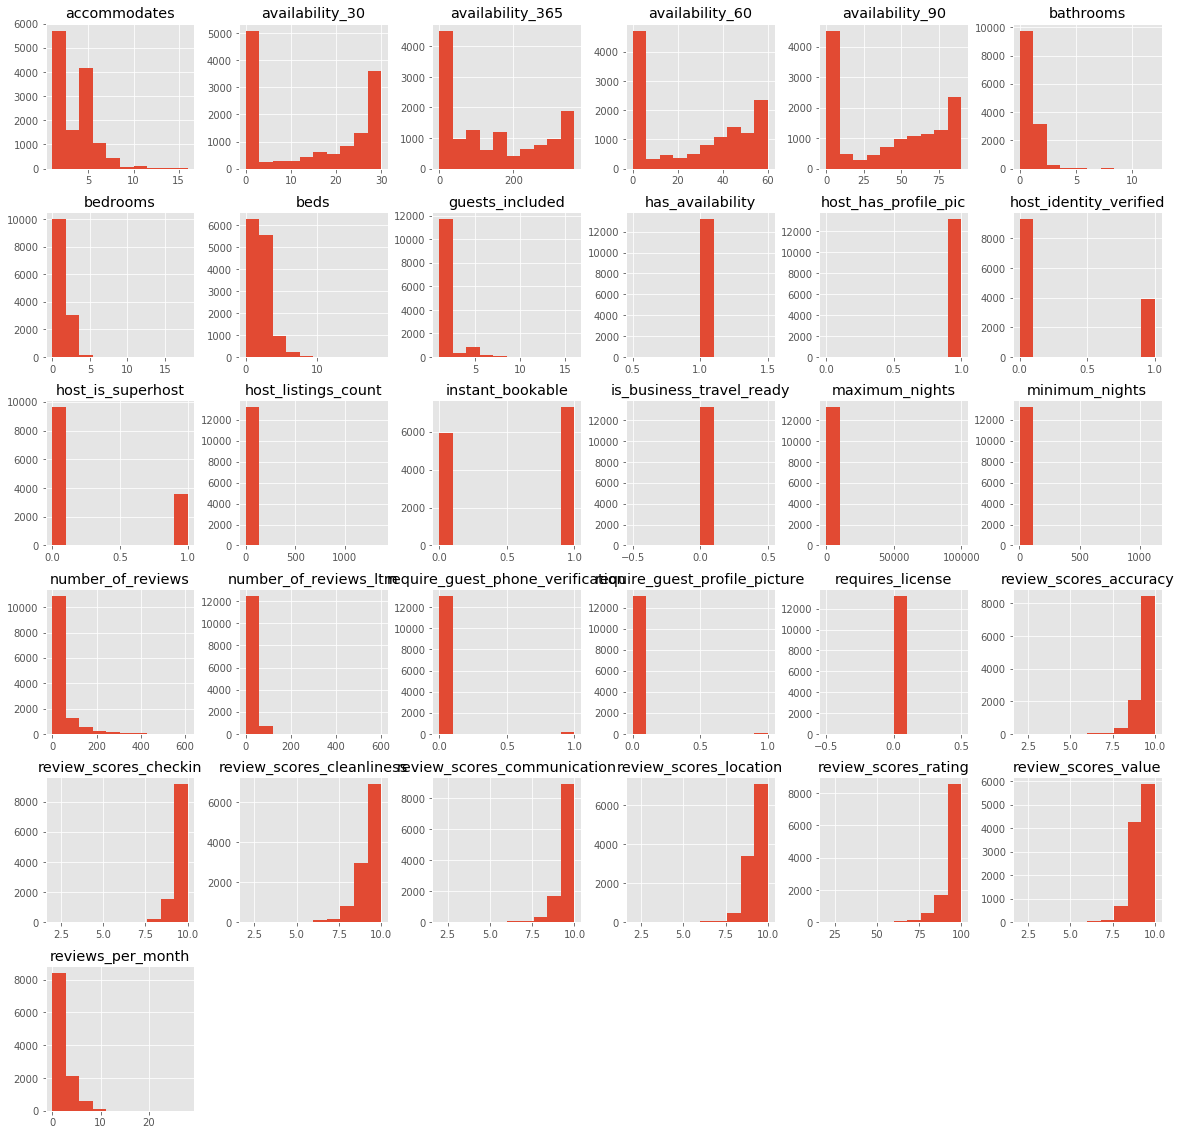

In [21]:
# Plotting the distribution of numerical and boolean categories
listings.hist(figsize=(20,20))
plt.show()

It can be easily observed that some columns only contain one category - they can be dropped as they include no additional information. 

**but**  minimum nights, maximum nights and host_listings_count appear to have one singular value, we have to check if it's true. 

As we can se below, it isn't, so these columns will be kept.

In [22]:
listings['has_availability'].value_counts()

1    13224
Name: has_availability, dtype: int64

In [23]:
listings['host_has_profile_pic'].value_counts()

1.0    13187
0.0       35
Name: host_has_profile_pic, dtype: int64

In [24]:
listings['maximum_nights'].value_counts()

1125     6657
180       847
30        839
365       636
90        388
         ... 
111         1
68          1
84          1
103         1
99999       1
Name: maximum_nights, Length: 201, dtype: int64

In [25]:
listings['minimum_nights'].value_counts()

1       4746
2       4151
3       2194
4        493
5        377
7        274
30       213
14       136
6        127
28        87
10        77
20        35
21        35
90        33
60        28
31        26
13        24
15        20
29        18
180       13
25        11
8          8
9          8
26         7
50         6
12         6
120        6
100        4
27         4
80         4
11         4
360        3
40         3
91         3
365        3
300        3
150        3
55         3
32         2
35         2
45         2
19         2
75         2
18         1
184        1
16         1
24         1
23         1
56         1
190        1
130        1
200        1
92         1
78         1
1000       1
1125       1
58         1
17         1
181        1
53         1
999        1
Name: minimum_nights, dtype: int64

In [26]:
listings['host_listings_count'].value_counts()

1.0       5185
2.0       1804
0.0       1226
3.0        894
4.0        445
5.0        363
6.0        352
8.0        236
7.0        225
10.0       170
9.0        164
17.0       142
14.0       134
11.0       132
43.0       130
13.0       120
103.0       96
15.0        95
108.0       94
16.0        93
12.0        81
86.0        79
24.0        76
21.0        74
20.0        59
96.0        58
28.0        55
52.0        52
32.0        52
35.0        51
18.0        45
19.0        44
27.0        43
47.0        42
34.0        41
37.0        41
38.0        38
39.0        34
60.0        31
29.0        28
22.0        18
135.0       17
41.0        14
26.0         8
23.0         5
445.0        5
674.0        4
647.0        4
1366.0       4
694.0        3
701.0        3
25.0         3
181.0        2
849.0        2
629.0        1
184.0        1
1247.0       1
1133.0       1
46.0         1
661.0        1
Name: host_listings_count, dtype: int64

In [27]:
listings.drop(['has_availability', 
         'host_has_profile_pic', 
         'is_business_travel_ready', 
         'require_guest_phone_verification', 
         'require_guest_profile_picture', 
         'requires_license'], axis=1, inplace=True)

In [28]:
listings.head()

,experiences_offered,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15883,none,2009-12-11,within an hour,100%,93%,0.0,6.0,1.0,Donaustadt,Bed and breakfast,Hotel room,3,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Breakfast,""Free st...",$85.00,NaN,NaN,2,$10.00,1,365,5 days ago,26,46,66,314,11,2,2015-04-10,2020-02-19,95.0,10.0,10.0,10.0,10.0,9.0,9.0,1,moderate,0.18
38768,none,2010-07-14,within an hour,100%,100%,0.0,3.0,0.0,Leopoldstadt,Apartment,Entire home/apt,5,1.0,1.0,3.0,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",$65.00,$150.00,$35.00,2,$12.00,3,100,5 days ago,10,29,50,201,313,41,2011-03-23,2020-03-04,95.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict_14_with_grace_period,2.86
40625,none,2010-07-20,within an hour,97%,75%,1.0,16.0,1.0,Rudolfsheim-Fnfhaus,Apartment,Entire home/apt,6,1.0,2.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$130.00,$0.00,$55.00,5,$15.00,1,180,2 weeks ago,30,48,69,324,153,25,2010-08-04,2020-01-04,97.0,10.0,10.0,10.0,10.0,9.0,9.0,1,moderate,1.31
51287,none,2010-07-14,within an hour,100%,100%,0.0,3.0,0.0,Leopoldstadt,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",$60.00,$150.00,$30.00,2,$8.00,3,100,5 days ago,13,22,47,137,294,50,2011-01-27,2020-02-26,92.0,10.0,9.0,10.0,10.0,10.0,9.0,0,strict_14_with_grace_period,2.64
70568,none,2011-01-22,within a day,92%,29%,1.0,7.0,1.0,Donaustadt,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",$59.00,$150.00,$40.00,2,$15.00,3,365,4 months ago,30,60,90,365,10,0,2011-04-12,2016-10-03,94.0,9.0,10.0,9.0,10.0,9.0,9.0,0,strict_14_with_grace_period,0.09


## Description of each column and Cleaning individual columns

+ *experiences_offered - slightly unclear as it does not appear to directly relate to Airbnb Experiences, but this seems to be the main recommended category of travel type, e.g. business* **dropped**
+ **host_since** - date that the host first joined Airbnb
+ **host_response_time** - average amount of time the host takes to reply to messages
+ **host_response_rate** - proportion of messages that the host replies to
+ **host_acceptance_rate** - proportion of requests accepted by the host
+ **host_is_superhost** - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
+ **host_listings_count** - how many listings the host has in total
+ **host_identity_verified** - whether or not the host has been verified with id
+ neighbourhood_cleansed - the neighbourhood the property is in
+ **property_type** - type of property, e.g. house or flat
+ room_type - type of listing, e.g. entire home, private room or shared room
+ accommodates - how many people the property accommodates
+ **bathrooms** - number of bathrooms
+ **bedrooms** - number of bedrooms
+ **beds** - number of beds
+ **bed_type** - type of bed, e.g. real bed or sofa-bed
+ **amenities** - list of amenities
+ **price** - nightly advertised price (the target variable)
+ **security_deposit** - the amount required as a security deposit
+ **cleaning_fee** - the amount of the cleaning fee (a fixed amount paid per booking)
+ guests_included - the number of guests included in the booking fee
+ **extra_people** - the price per additional guest above the guests_included price
+ minimum_nights - the minimum length of stay
+ maximum_nights - the maximum length of stay
+ *calendar_updated - when the host last updated the calendar* **dropped**
+ availability_30 - how many nights are available to be booked in the next 30 days**dropped**
+ availability_60 - how many nights are available to be booked in the next 60 days**dropped**
+ availability_90 - how many nights are available to be booked in the next 90 days**dropped**
+ **availability_365** - how many nights are available to be booked in the next 365 days
+ number_of_reviews - the number of reviews left for the property
+ number_of_reviews_ltm - the number of reviews left for the property in the last twelve months
+ **first_review** - the date of the first review
+ last_review - the date of the most recent review **dropped**
+ **review_scores_rating** - guests can score properties overall from 1 to 5 stars
+ **review_scores_accuracy** - guests can score the accuracy of a property's description from 1 to 5 stars
+ **review_scores_cleanliness** - guests can score a property's cleanliness from 1 to 5 stars
+ **review_scores_checkin** - guests can score their check-in from 1 to 5 stars
+ **review_scores_communication** - guests can score a host's communication from 1 to 5 stars
+ **review_scores_location** - guests can score a property's location from 1 to 5 stars
+ **review_scores_value** - guests can score a booking's value for money from 1 to 5 stars
+ instant_bookable - whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)
+ cancellation_policy - the type of cancellation policy, e.g. strict or moderate
+ reviews_per_month - calculated field of the average number of reviews left by guest each month

### experiences_offered

This column includes only the value *none* so it will be dropped

In [29]:
listings["experiences_offered"].value_counts()

none    13224
Name: experiences_offered, dtype: int64

In [30]:
listings.drop('experiences_offered', axis =1, inplace=True)

### host_since

This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform (*host_days_active*), measured from the date that the data was scraped (17 March 2020). 

The original column will be left in initially for exploratory data analysis(EDA), and dropped later.

In [31]:
# converting to datetime
listings.host_since = pd.to_datetime(listings.host_since)

# calculating the number of days
listings['host_days_active'] = (datetime(2020, 3, 17) - listings.host_since).astype('timedelta64[D]')

# mean and median

print("Mean days as host:", round(listings['host_days_active'].mean(),0))
print("Median days as host:", round(listings['host_days_active'].median(),0))

# replacing null values with the median
listings.host_days_active.fillna(listings.host_days_active.median(), inplace=True)


Mean days as host: 1503.0
Median days as host: 1520.0


### host_response_time

Aprox. 28% of rows don't have a value for this column. 7% of the rows have also not yet been reviewed - these are probably properties which have not yet had a completed stay (most likely properties which have not yet had a booking, although may also include properties that have a booking currently occuring). These listings will be retained in the data because they are still legitimate properties with advertised prices, and are still part of the comparative market when considering the price for which to advertise your Airbnb listing. However, if the dataset being used had the actual average price paid as its target, it would be necessary to drop these rows because they would not have a value, as they have not yet been booked.

It is worth noting, however, that this group of listings probably also contains a large number of 'inactive' listings. These are properties which have been speculatively listed on Airbnb but either have their calendars closed (so no stays can be booked), or have prices which are notably higher than other properties in their area. The latter occurs in some cases when people who regularly live in a property put their property on Airbnb at a high price just to see if anyone is willing to book at that price (some Airbnb listings are indeed booked at very high prices). 

Because host_response_time is unknown for so many listings, it will be retained as its own category, 'unknown'.

In [32]:
print("Null values:", listings.host_response_time.isna().sum())
print(f"Proportion: {round((listings.host_response_time.isna().sum()/len(listings))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
print( "host_response_time and first_review are na: ",len(listings[listings[['host_response_time', 'first_review']].isnull().sum(axis=1) == 2]))
print(f"proportion: {round((len(listings[listings[['host_response_time', 'first_review']].isnull().sum(axis=1) == 2]) / len(listings)*100),1)}%")


Null values: 3686
Proportion: 27.9%
host_response_time and first_review are na:  952
proportion: 7.2%


In [33]:
listings.host_response_time.fillna("unknown", inplace=True)
listings.host_response_time.value_counts(normalize=True)

within an hour        0.538415
unknown               0.278736
within a few hours    0.098684
within a day          0.071007
a few days or more    0.013158
Name: host_response_time, dtype: float64

### host_response_rate

A similar story is true for host_response_rate, with about a third of values being null. This will also be kept as its own category, after grouping other values into meaningful groups (i.e. transforming this into a categorical feature, rather than a numerical one). Because about 70% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins. The nan values will be replaced with the value *unknown* .

In [34]:
print("Null values:", listings.host_response_rate.isna().sum())
print(f"Proportion: {round((listings.host_response_rate.isna().sum()/len(listings))*100, 1)}%")

Null values: 3686
Proportion: 27.9%


In [35]:
# Removing the % sign from the host_response_rate string and converting to a numerical value
listings.host_response_rate = listings.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(listings['host_response_rate'].mean(),0))
print("Median host response rate:", listings['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((listings.host_response_rate == 100.0).sum()/listings.host_response_rate.count())*100,1)}%")

Mean host response rate: 95.0
Median host response rate: 100.0
Proportion of 100% host response rates: 77.6%


In [36]:
# Bin into four categories
listings.host_response_rate = pd.cut(listings.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
listings.host_response_rate = listings.host_response_rate.astype('str')

# Replace nulls with 'unknown'
listings.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
listings.host_response_rate.value_counts()

100%       7402
unknown    3686
50-89%     1130
90-99%      756
0-49%       250
Name: host_response_rate, dtype: int64

### host_acceptance_rate

The same data processing will be done for this column also. Transformed into bins as a categorical feature.

In [37]:
print("Null values:", listings.host_acceptance_rate.isna().sum())
print(f"Proportion: {round((listings.host_acceptance_rate.isna().sum()/len(listings))*100, 1)}%")

Null values: 2275
Proportion: 17.2%


In [38]:
# Removing the % sign from the host_acceptance_rate string and converting to a numerical value
listings.host_acceptance_rate = listings.host_acceptance_rate.str[:-1].astype('float64')

print("Mean host acceptance rate:", round(listings['host_acceptance_rate'].mean(),0))
print("Median host acceptance rate:", listings['host_acceptance_rate'].median())
print(f"Proportion of 100% host acceptance rates: {round(((listings.host_acceptance_rate == 100.0).sum()/listings.host_acceptance_rate.count())*100,1)}%")

Mean host acceptance rate: 88.0
Median host acceptance rate: 99.0
Proportion of 100% host acceptance rates: 45.7%


In [39]:
# Bin into four categories
listings.host_acceptance_rate = pd.cut(listings.host_acceptance_rate, bins = [0, 50, 90, 99, 100], labels = ['0-49%', '50-89%', '90-99%', '100%'], include_lowest = True)

# Converting to string
listings.host_acceptance_rate = listings.host_acceptance_rate.astype('str')

# Replace nulls with 'unknown'
listings.host_acceptance_rate.replace('nan', 'unknown', inplace = True)

# Category counts
listings.host_acceptance_rate.value_counts()

100%       5000
90-99%     2724
unknown    2275
50-89%     2267
0-49%       958
Name: host_acceptance_rate, dtype: int64

### host_is_superhost

There are 2 rows without a value for multiple host-related columns.These rows will be dropped.

In [40]:
# Number of rows without a value for multiple host-related columns
# len(listings[listings.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 'host_identity_verified'] ].isnull().sum(axis=1) == 4])
# KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported

len(listings[listings[['host_since', 'host_is_superhost', 'host_listings_count', 'host_identity_verified']].isnull().sum(axis = 1) == 4]) 

2

In [41]:
listings.dropna(subset = ['host_since'], inplace = True)

### host_listings_count

There are some hosts which have 0 listings - 1226. This rows will be dropped.

In [42]:
len(listings[listings["host_listings_count"] ==0])

1226

In [43]:
len(listings)

13222

In [44]:
listings.index.is_unique

True

In [45]:
listings.drop(listings[listings["host_listings_count"] ==0].index, axis=0, inplace=True)

In [46]:
len(listings)

11996

### property_type

There is a fair number of types of properties listed:
+ Apartment                 11762
+ Condominium                 413
+ Serviced apartment          264
+ House                       254
+ Loft                        238
+ Boutique hotel               63
+ Bed and breakfast            38
+ Townhouse                    37
+ Guest suite                  30
+ Hostel                       20
+ Guesthouse                   20
+ Villa                        19
+ Hotel                        13
+ Other                        10
+ Bungalow                      9
+ Aparthotel                    7
+ Tiny house                    5
+ Cabin                         3
+ Castle                        2
+ Cave                          2
+ Earth house                   2
+ Cottage                       2
+ Casa particular (Cuba)        1
+ Dome house                    1
+ Treehouse                     1
+ Chalet                        1
+ Bus                           1
+ Vacation home                 1
+ Farm stay                     1
+ Camper/RV                     1
+ Lighthouse                    1

By far, the most interesting thing is that in Vienna on AIRBNB are listed 2 catles and 2 caves. 
Some cleaning of property types is required as there are a large number of categories with only a few listings. 
The categories 'apartment', 'house' and 'other' will be used, as most properties can be classified as either apartments or houses.(*others* will include hotels, hostels as there are few listings of those)

In [47]:
# replacing categories that are types of houses or apartments
listings.property_type.replace({
    'Condominium': 'Apartment',
    'Aparthotel': 'Apartment',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Cabin': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Townhouse': 'House',
    'Chalet': 'House'  
    }, inplace=True)

In [48]:
# Replacing other categories with 'other'
listings.loc[~listings.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [49]:
listings.property_type.value_counts()

Apartment    11512
House          296
Other          188
Name: property_type, dtype: int64

### bathrooms, bedrooms and beds

Missing values will be replaced with the median.

In [50]:
listings[['bathrooms', 'bedrooms', 'beds']].isna().sum()

bathrooms     5
bedrooms     19
beds         53
dtype: int64

In [51]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    listings[col].fillna(listings[col].median(), inplace=True)

### bed_type

Most listings have the same bed type, so this feature will be dropped.

In [52]:
listings.bed_type.value_counts()

Real Bed         11821
Pull-out Sofa      121
Couch               25
Futon               24
Airbed               5
Name: bed_type, dtype: int64

In [53]:
listings.drop('bed_type', axis = 1, inplace = True)

### amenities

Amenities is a list of additional features in the property, e.g. whether it has a TV or parking. Examples are below:

In [54]:
listings.amenities[:1].values

array(['{TV,Wifi,"Air conditioning",Breakfast,"Free street parking",Heating,"Family/kid friendly","Smoke detector",Essentials,Shampoo,Hangers,"Hair dryer","Laptop friendly workspace","High chair","Pack ’n Play/travel crib","Hot water","Bed linens","Patio or balcony","Luggage dropoff allowed"}'],
      dtype=object)

In [55]:
# Creating a set of all possible amenities
amenities_list = list(listings.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')

In [56]:
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)  # set - distinct and ordered
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'Amazon Echo',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Balcony',
 'Barbecue utensils',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Bread maker',
 'Breakfast',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Central air conditioning',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Double oven',
 'Dryer',
 'EV charger',
 'Elevator',
 'En suite bathroom',
 'Esp

In the list above, some amenities are more important than others (e.g. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (e.g. 'Mudroom'). 

A selection of the more important amenities will be extracted. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

The amenities chosen are (slashes indicate separate categories that can be combined):

+ 24-hour check-in
+ Air conditioning/central air conditioning
+ Amazon Echo/Apple TV/DVD player/game console/Netflix/projector and screen/smart TV (i.e. non-basic electronics)
+ BBQ grill/fire pit/propane barbeque
+ Balcony/patio or balcony
+ Beach view/beachfront/lake access/mountain view/ski-in ski-out/waterfront (i.e. great location/views)
+ Bed linens
+ Breakfast
+ Cable TV/TV
+ Coffee maker/espresso machine
+ Cooking basics
+ Dishwasher/Dryer/Washer/Washer and dryer
+ Elevator
+ Exercise equipment/gym/private gym/shared gym
+ Family/kid friendly, or anything containing 'children'
+ Free parking on premises/free street parking/outdoor parking/paid parking off premises/paid parking on premises
+ Garden or backyard/outdoor seating/sun loungers/terrace
+ Host greets you
+ Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool
+ Internet/pocket wifi/wifi
+ Long term stays allowed
+ Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s)
+ Private entrance
+ Safe/security system
+ Self check-in
+ Smoking allowed
+ Step-free access/wheelchair accessible, or anything containing 'accessible'
+ Suitable for events


The amenities will pe transformed into separate columns with 0/1 values for each listing that doesn't have/has the specific amenitie.

In [57]:
listings.loc[listings['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
listings.loc[listings['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
listings.loc[listings['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|HBO GO|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
listings.loc[listings['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
listings.loc[listings['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
listings.loc[listings['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
listings.loc[listings['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
listings.loc[listings['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
listings.loc[listings['amenities'].str.contains('TV'), 'tv'] = 1
listings.loc[listings['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
listings.loc[listings['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
listings.loc[listings['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
listings.loc[listings['amenities'].str.contains('Elevator'), 'elevator'] = 1
listings.loc[listings['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
listings.loc[listings['amenities'].str.contains('Family/kid friendly|Children’s books and toys|Children’s dinnerware'), 'child_friendly'] = 1
listings.loc[listings['amenities'].str.contains('parking'), 'parking'] = 1
listings.loc[listings['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
listings.loc[listings['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
listings.loc[listings['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
listings.loc[listings['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
listings.loc[listings['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
listings.loc[listings['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)|Other pet(s)|Pets allowed|Pets live on this property'), 'pets_allowed'] = 1
listings.loc[listings['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
listings.loc[listings['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
listings.loc[listings['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
listings.loc[listings['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
listings.loc[listings['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
listings.loc[listings['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

D:\installs\Anaconda\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [58]:
listings.columns[42:]

Index(['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq',
       'balcony', 'nature_and_views', 'bed_linen', 'breakfast', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator', 'gym',
       'child_friendly', 'parking', 'outdoor_space', 'host_greeting',
       'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed',
       'private_entrance', 'secure', 'self_check_in', 'smoking_allowed',
       'accessible', 'event_suitable'],
      dtype='object')

One way to reduce the number of features (to avoid the curse of dimensionality) is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. 

Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

In [59]:
cols_to_replace_nulls = listings.iloc[:,42:].columns
listings[cols_to_replace_nulls] = listings[cols_to_replace_nulls].fillna(0)

# produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in listings.iloc[:,42:].columns:
    if listings[col].sum() < len(listings)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

['check_in_24h', 'high_end_electronics', 'bbq', 'nature_and_views', 'breakfast', 'gym', 'outdoor_space', 'hot_tub_sauna_or_pool', 'accessible', 'event_suitable']


In [60]:
# dropping infrequent amenity features
listings.drop(infrequent_amenities, axis=1, inplace=True)

# dropping the original amenity feature
listings.drop('amenities', axis=1, inplace=True)

In [61]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11996 entries, 15883 to 42926580
Data columns (total 59 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   host_since                   11996 non-null  datetime64[ns]
 1   host_response_time           11996 non-null  object        
 2   host_response_rate           11996 non-null  object        
 3   host_acceptance_rate         11996 non-null  object        
 4   host_is_superhost            11996 non-null  float64       
 5   host_listings_count          11996 non-null  float64       
 6   host_identity_verified       11996 non-null  float64       
 7   neighbourhood_cleansed       11996 non-null  object        
 8   property_type                11996 non-null  object        
 9   room_type                    11996 non-null  object        
 10  accommodates                 11996 non-null  int64         
 11  bathrooms                    11996

In [62]:
listings.columns[42:]

Index(['balcony', 'bed_linen', 'tv', 'coffee_machine', 'cooking_basics',
       'white_goods', 'elevator', 'child_friendly', 'parking', 'host_greeting',
       'internet', 'long_term_stays', 'pets_allowed', 'private_entrance',
       'secure', 'self_check_in', 'smoking_allowed'],
      dtype='object')

### price (in dollars)

Price will be converted to an integer - currently it is a string because there is a currency sign.

In [63]:
listings.price = listings.price.str[1:-3]
listings.price = listings.price.str.replace(",", "")
listings.price = listings.price.astype('int64')

### security_deposit (in dollars)

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

Having a missing value for security deposit is functionally the same as having a security deposit of 0, so missing values will be replaced with 0.

In [64]:
listings.security_deposit.value_counts()

$0.00        4887
$100.00       742
$200.00       682
$300.00       465
$150.00       451
$500.00       361
$250.00       265
$400.00       141
$350.00        83
$1,000.00      78
$120.00        37
$90.00         33
$600.00        33
$95.00         24
$800.00        24
$450.00        17
$2,000.00      17
$99.00         16
$1,500.00      16
$700.00        11
$750.00        11
$550.00        11
$900.00        10
$85.00         10
$180.00         8
$91.00          6
$88.00          6
$3,000.00       6
$98.00          5
$480.00         5
$850.00         5
$110.00         4
$299.00         4
$2,500.00       4
$4,000.00       3
$190.00         3
$390.00         3
$1,800.00       3
$87.00          3
$75.00          3
$290.00         3
$199.00         2
$360.00         2
$280.00         2
$950.00         2
$86.00          2
$89.00          2
$94.00          2
$160.00         2
$70.00          2
$285.00         2
$84.00          2
$4,400.00       2
$140.00         2
$170.00         2
$990.00   

In [65]:
listings.security_deposit.isna().sum()

3436

In [66]:
listings.security_deposit = listings.security_deposit.str[1:-3]
listings.security_deposit = listings.security_deposit.str.replace(",", "")
listings.security_deposit.fillna(0, inplace=True)
listings.security_deposit = listings.security_deposit.astype('int64')

### cleaning_fee (in dollars)

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

As with security deposit, having a missing value for cleaning fee is functionally the same as having a cleaning fee of 0, so missing values will be replaced with 0.

In [67]:
listings.cleaning_fee.value_counts()

$30.00     968
$0.00      901
$20.00     809
$40.00     756
$35.00     636
$25.00     602
$10.00     580
$50.00     572
$15.00     549
$45.00     408
$60.00     231
$39.00     228
$5.00      213
$70.00     177
$29.00     172
$49.00     135
$59.00     125
$55.00     124
$80.00     109
$34.00     107
$100.00     92
$19.00      77
$65.00      70
$48.00      63
$90.00      60
$12.00      56
$28.00      52
$7.00       51
$120.00     51
$18.00      48
$9.00       42
$42.00      40
$38.00      34
$69.00      34
$75.00      34
$8.00       33
$119.00     32
$36.00      31
$17.00      29
$22.00      29
$6.00       28
$24.00      28
$79.00      27
$16.00      26
$47.00      25
$14.00      24
$150.00     24
$85.00      20
$52.00      18
$159.00     18
$27.00      17
$26.00      17
$44.00      16
$58.00      15
$21.00      15
$95.00      14
$23.00      14
$4.00       14
$99.00      14
$32.00      14
$199.00     13
$43.00      12
$63.00      12
$110.00     10
$89.00      10
$46.00       9
$13.00    

In [68]:
listings.cleaning_fee.isna().sum()

2008

In [69]:
listings.cleaning_fee = listings.cleaning_fee.str[1:-3]
listings.cleaning_fee = listings.cleaning_fee.str.replace(",", "")
listings.cleaning_fee.fillna(0, inplace=True)
listings.cleaning_fee = listings.cleaning_fee.astype('int64')

### extra_people - fee per extra guest in dollars

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

As with security deposit, having a missing value for extra people is functionally the same as having an extra people fee of 0, so missing values will be replaced with 0.

In [70]:
listings.extra_people.isna().sum()

0

In [71]:
listings.extra_people = listings.extra_people.str[1:-3]
listings.extra_people = listings.extra_people.str.replace(",", "")
listings.extra_people.fillna(0, inplace=True)
listings.extra_people = listings.extra_people.astype('int64')

In [72]:
listings.extra_people.value_counts()

0      5041
10     1661
15     1422
20      871
5       497
25      463
12      285
30      283
8       231
9       116
35      110
19      107
7        98
18       93
13       70
11       66
22       60
17       59
40       55
6        49
50       49
14       41
16       38
4        31
23       31
29       22
28       15
24       15
45       15
26       10
39        9
36        9
100       8
55        6
65        5
49        5
21        5
250       5
60        5
31        4
34        3
27        3
37        2
43        2
69        2
75        2
150       2
120       2
38        2
32        1
200       1
130       1
33        1
41        1
42        1
58        1
66        1
90        1
70        1
95        1
Name: extra_people, dtype: int64

### calendar_updated

There are 85 categories for calendar_updated, and it is not entirely clear what this feature is adding to the model (a host might update their calendar for multiple different reasons). Therefore this column will be dropped.

In [73]:
print("Number of categories:", listings.calendar_updated.nunique())
print("\nTop five categories:")
listings.calendar_updated.value_counts()[:5]

Number of categories: 85

Top five categories:


today           1656
a week ago       994
2 weeks ago      891
2 months ago     838
3 months ago     596
Name: calendar_updated, dtype: int64

In [74]:
listings.drop('calendar_updated', axis=1, inplace=True)

### availability

There are multiple different measures of availability, which will be highly correlated with each other. 

Only one will be retained for the purpose of this project - availability_365. 

**However**, in Vienna, there is no legal limit to differentiate between short and log term lending. 

In [75]:
listings.availability_365.unique()

array([314, 201, 324, 137, 365,  99,   0, 278, 333, 301, 264, 236, 310,
       210, 158, 296, 302, 147, 337, 235, 291, 360, 182,  63,  31,  59,
       216, 167, 151, 263, 223,  44, 255, 332, 357, 349, 351, 344, 342,
       341, 364, 312, 335,  75, 224, 340, 306,  87, 209, 237, 247, 250,
       361, 352, 293, 217, 322, 309, 319, 298, 222, 260,  74, 311,  46,
       134, 334, 196, 261, 267, 115, 271, 356, 186, 331, 308, 249, 350,
       317,  89, 281, 355, 274, 292, 108, 169,  95, 318, 221, 208, 197,
       284, 313, 316,  90, 345, 288, 286, 220, 162, 226, 225, 202, 327,
       325, 175, 285, 200, 253, 287, 254, 300, 358, 119,  23, 172,  21,
       117, 336, 258,  56, 346, 329, 338, 279, 330, 207, 280, 150, 363,
       178, 362, 168, 252, 259, 276, 269, 339, 180, 100, 320, 275, 303,
        18, 289, 164,  10, 160, 229, 304, 131, 141, 170,  88,  45,  73,
        83, 212, 353, 101, 230, 248, 305, 188, 343, 243, 323, 211, 268,
       118, 326, 242, 184, 232, 307, 290,  66, 103, 179, 145, 35

In [76]:
listings.drop(['availability_30', 'availability_60', 'availability_90'], axis=1, inplace=True)

In [77]:
listings.tail(10)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month,host_days_active,air_conditioning,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
42879879,2019-12-03,within an hour,100%,90-99%,0.0,3.0,0.0,Innere Stadt,Apartment,Entire home/apt,4,1.5,1.0,2.0,199,0,0,1,0,1,365,364,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,NaN,105.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
42886246,2016-05-11,within an hour,100%,90-99%,1.0,3.0,0.0,Rudolfsheim-Fnfhaus,Apartment,Entire home/apt,4,1.0,1.0,3.0,50,0,50,1,0,2,1125,180,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,flexible,NaN,1406.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
42891458,2017-10-21,within a few hours,100%,50-89%,0.0,3.0,0.0,Liesing,Apartment,Entire home/apt,5,1.0,1.0,0.0,41,200,27,1,19,1,1125,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,flexible,NaN,878.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
42909495,2010-07-14,within an hour,100%,100%,0.0,3.0,0.0,Leopoldstadt,Apartment,Entire home/apt,2,1.0,0.0,2.0,55,0,0,1,0,2,30,83,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,NaN,3534.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
42913533,2015-05-09,unknown,unknown,0-49%,0.0,1.0,0.0,Alsergrund,Apartment,Entire home/apt,2,1.0,1.0,1.0,75,800,50,1,0,28,1125,197,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,strict_14_with_grace_period,NaN,1774.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
42913973,2011-09-04,within an hour,100%,100%,0.0,27.0,0.0,Leopoldstadt,Apartment,Entire home/apt,1,1.0,0.0,1.0,12,0,15,1,0,13,60,38,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,flexible,NaN,3117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
42914572,2011-09-04,within an hour,100%,100%,0.0,27.0,0.0,Leopoldstadt,Apartment,Entire home/apt,2,1.0,0.0,2.0,20,0,0,1,0,13,60,98,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,flexible,NaN,3117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
42924508,2013-09-02,unknown,unknown,50-89%,0.0,1.0,1.0,Hernals,Apartment,Entire home/apt,4,1.0,2.0,4.0,60,0,0,1,0,3,1125,323,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,flexible,NaN,2388.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
42926498,2011-09-04,within an hour,100%,100%,0.0,27.0,0.0,Leopoldstadt,Apartment,Entire home/apt,4,1.0,0.0,2.0,20,0,0,1,0,15,90,99,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,flexible,NaN,3117.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### first_review and last_review

About 15% of listings have not had a review written for them. This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information - reviews are very important in people's decisions to book, and therefore price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. 

Also, the missing values here are not really missing values, as the fact that they are NaNs is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting model work able to predict prices for any Airbnb listing, including brand new listings, is is actually beneficial to keep them in. Therefore, these will be kept as an 'unknown' category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical.

In [78]:
print(f"Null values in 'first_review': {round(100*listings.first_review.isna().sum()/len(listings),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*listings.review_scores_rating .isna().sum()/len(listings),1)}%")

Null values in 'first_review': 14.1%
Null values in 'review_scores_rating': 15.0%


In [79]:
listings.first_review = pd.to_datetime(listings.first_review) # converting to datetime

# calculating the number of days between the first review and the date the data was scraped
listings['time_since_first_review'] = (datetime(2020, 3, 17) - listings.first_review).astype('timedelta64[D]')
listings.time_since_first_review.isna().sum()

1688

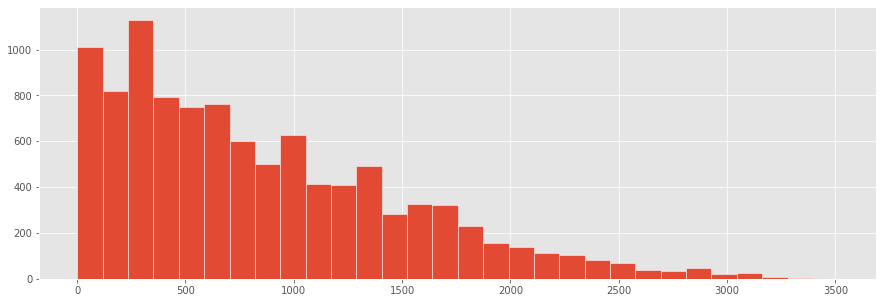

In [80]:
# distribution of the number of days since first review
listings.time_since_first_review.hist(figsize=(15,5), bins=30, ec = "white");

In [81]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """

    listings[col] = pd.cut(listings[col], bins=bins, labels=labels, include_lowest=True)
    listings[col] = listings[col].astype('str')
    listings[col].replace('nan', na_label, inplace=True) 

In [82]:
# binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(listings.time_since_first_review)],
           labels=['0-6_months',
                   '6-12_months',
                   '1-2_years',
                   '2-3_years',
                   '4+_years'],
           na_label='no_reviews')

In [83]:
listings.time_since_first_review.value_counts()

2-3_years      3037
1-2_years      2443
4+_years       1821
no_reviews     1688
6-12_months    1590
0-6_months     1417
Name: time_since_first_review, dtype: int64

The same process will be followed for *last_review*

In [84]:
listings.last_review = pd.to_datetime(listings.last_review) # converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
listings['time_since_last_review'] = (datetime(2020, 3, 17) - listings.last_review).astype('timedelta64[D]')
listings.time_since_last_review.isna().sum()

1688

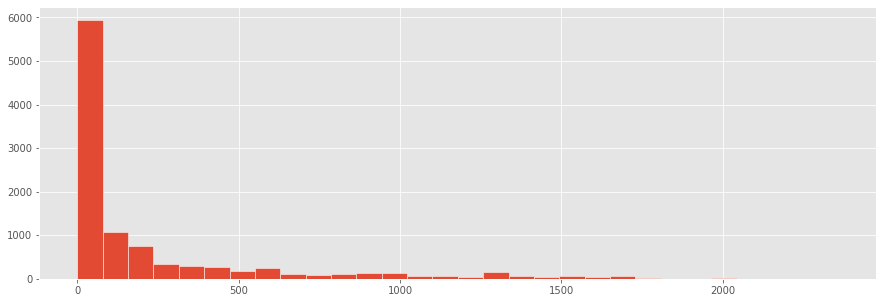

In [85]:
# distribution of the number of days since last review
listings.time_since_last_review.hist(figsize=(15,5), bins=30, ec = "white");

In [86]:
# binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(listings.time_since_last_review)],
           labels=['0-2_weeks',
                   '2-8_weeks',
                   '2-6_months',
                   '6-12_months',
                   '1+_year'],
           na_label='no_reviews')

In [87]:
listings.time_since_last_review.value_counts()

2-8_weeks      2745
2-6_months     2725
1+_year        1983
0-2_weeks      1767
no_reviews     1688
6-12_months    1088
Name: time_since_last_review, dtype: int64

In [88]:
# dropping last_review - first_review will be kept for EDA and dropped later
listings.drop('last_review', axis=1, inplace=True)

### review ratings columns

As above, listings without reviews will be kept and replaced with 'unknown'. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. 

The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating).

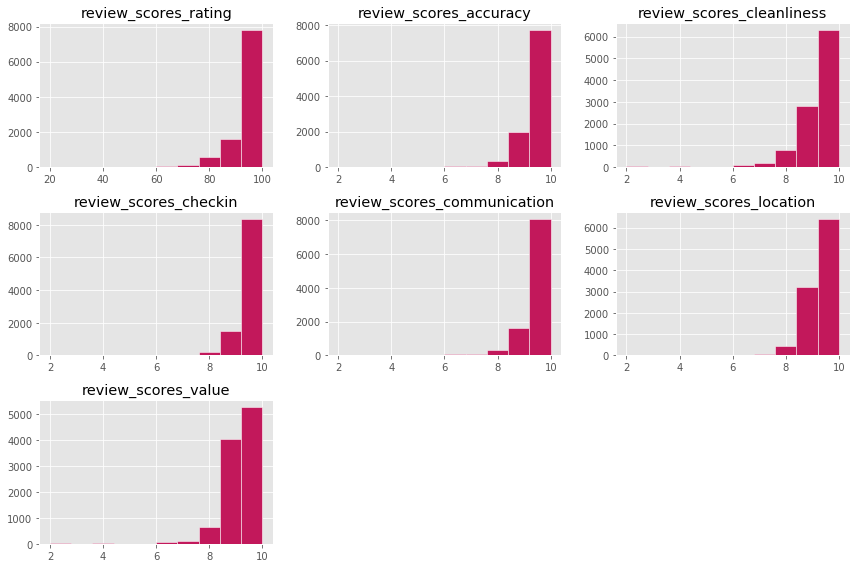

In [89]:
# checking the distributions of the review ratings columns
variables_to_plot = list(listings.columns[listings.columns.str.startswith("review_scores") == True])

fig = plt.figure(figsize=(12,8))

for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    listings[var_name].hist(bins=10,ax=ax, ec = "white", color = "#c2185b")
    ax.set_title(var_name)
    
fig.tight_layout()
plt.show()

In [90]:
# creating a list of all review columns that are scored out of 10 - removing review_scores_rating
variables_to_plot.pop(0)

'review_scores_rating'

In [91]:
# binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no_reviews')

In [92]:
# binning column scored out of 100 - review_scores_rating
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no_reviews')

### number_of_reviews_ltm and reviews_per_month

These will be highly correlated with number_of_reviews and so will be dropped.

In [93]:
listings.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

### cancellation_policy

Some cleaning of cancellation policy types is required, in order to categorise the three very small categories into the three larger categories (e.g. the super strict options are only available to long-term Airbnb hosts, and is invitation only).

In [94]:
listings.cancellation_policy.value_counts()

strict_14_with_grace_period    4321
moderate                       3901
flexible                       3630
super_strict_30                 120
super_strict_60                  23
strict                            1
Name: cancellation_policy, dtype: int64

In [95]:
# Replacing categories
listings.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    }, inplace=True)

In [96]:
listings.tail()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,host_days_active,air_conditioning,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,time_since_first_review,time_since_last_review
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
42913973,2011-09-04,within an hour,100%,100%,0.0,27.0,0.0,Leopoldstadt,Apartment,Entire home/apt,1,1.0,0.0,1.0,12,0,15,1,0,13,60,38,0,NaT,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,1,flexible,3117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,no_reviews,no_reviews
42914572,2011-09-04,within an hour,100%,100%,0.0,27.0,0.0,Leopoldstadt,Apartment,Entire home/apt,2,1.0,0.0,2.0,20,0,0,1,0,13,60,98,0,NaT,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,1,flexible,3117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,no_reviews,no_reviews
42924508,2013-09-02,unknown,unknown,50-89%,0.0,1.0,1.0,Hernals,Apartment,Entire home/apt,4,1.0,2.0,4.0,60,0,0,1,0,3,1125,323,0,NaT,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,1,flexible,2388.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,no_reviews,no_reviews
42926498,2011-09-04,within an hour,100%,100%,0.0,27.0,0.0,Leopoldstadt,Apartment,Entire home/apt,4,1.0,0.0,2.0,20,0,0,1,0,15,90,99,0,NaT,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,1,flexible,3117.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,no_reviews,no_reviews
42926580,2011-09-04,within an hour,100%,100%,0.0,27.0,0.0,Leopoldstadt,Apartment,Entire home/apt,4,1.0,1.0,3.0,30,0,0,1,0,13,90,98,0,NaT,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,no_reviews,1,flexible,3117.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,no_reviews,no_reviews


# Exploratory Data Analysis

## Time Series

**Question: how long have hosts been listing properties on Airbnb in Vienna?**

Answer: the oldest Vienna listing that is currently live on Airbnb was first listed on the site in December 2008. 

From 2012 onwards, the number of listings started increasing considerably. However, growth in the number of new hosts (of those currently listing on the site) has not been increasing since 2016. In 2018 the Viennese government proposed higher penalties for individuals short-term  letting their homes; however we see a slight increse since 2018 in hosts joining Airbnb.

A high level of seasonality is evident, with notable peaks in the summer when people put properties online to take advantage of the increased number of tourists in the summer holidays.

???There is a big peak in the number of hosts joining Airbnb in 2015. 

In [97]:
print(f"On March 2020:\nOldest host joind on {min(listings.host_since).strftime('%d.%m.%Y')},\nNewest host joined on {max(listings.host_since).strftime('%d.%m.%Y')}.")

On March 2020:
Oldest host joind on 30.12.2008,
Newest host joined on 08.03.2020.


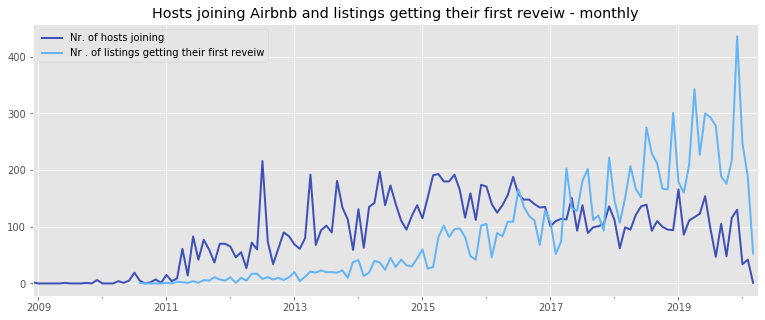

In [98]:
plt.figure(figsize=(13,5))

listings.set_index('host_since').resample('MS').size().plot(label='Nr. of hosts joining', color='#3f51b5', lw=2)
listings.set_index('first_review').resample('MS').size().plot(label='Nr . of listings getting their first reveiw', color='#64b5f6', lw = 2)

plt.title('Hosts joining Airbnb and listings getting their first reveiw - monthly')
plt.legend()
plt.xlim('2008-12-01', '2020-4-30') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')

plt.show()

In [99]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(listings.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(listings.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [100]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(bottom = 0.2, top=0.3, hspace=0.8)
    
    plt.subplot(411)
    plt.plot(df, label='Original', lw=3, color = '#1a237e')
    plt.legend(loc='upper left')
    
    plt.subplot(412)
    plt.plot(trend, label='Trend', lw=3, color = '#303f9f')
    plt.legend(loc='upper left')
    
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', lw=3, color = '#3f51b5')
    plt.legend(loc='upper left')
    
    plt.subplot(414)
    plt.plot(residual, label='Residuals', lw=3, color = '#7986cb')
    plt.legend(loc='upper left')
    plt.tight_layout()

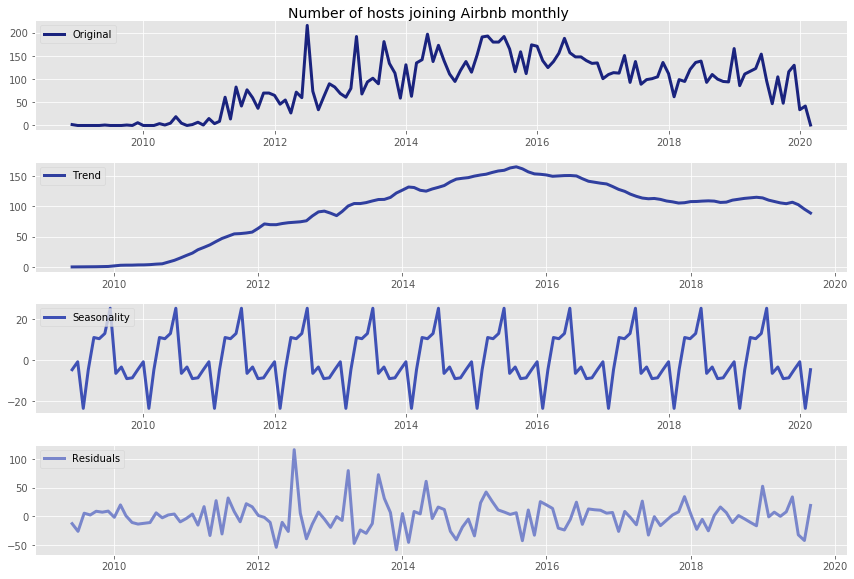

In [101]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb monthly')

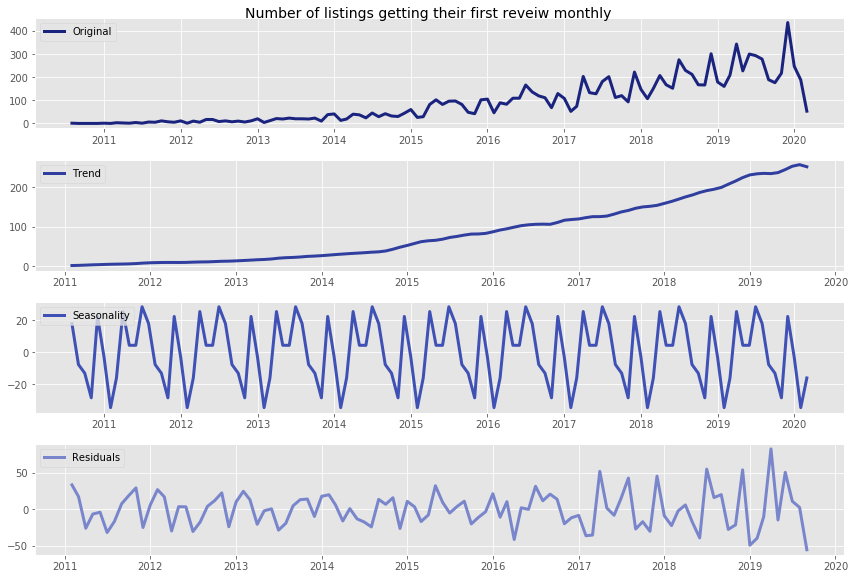

In [102]:
decompose_time_series(ts_first_review, title='Number of listings getting their first reveiw monthly')

**Question: are the different patterns in the growth in the number of hosts and the number of listings due to hosts increasingly owning multiple properties?**

Answer: there are a number of professional Airbnb management companies which host a large number of listings under a single host profile. The largest, E-Domizil, manages 4009 listings, while the second largest, Belvilla, managing 1247 listings.

However, there is no consistent upwards trend in the average number of properties managed by each host.

In [103]:
###  host_listings_count

print("\t host_listings_count column\n")
print(f"{int(round(100*len(listings[listings.host_listings_count == 1])/len(listings)))}% of the lsitings are coming from hosts with a sigle property")
print("\nMean host_listings_count: ", round(listings['host_listings_count'].mean(),0))
print("Median host_listings_count: ", listings['host_listings_count'].median())
print("Min host_listings_count: ", listings['host_listings_count'].min())
print("Max host_listings_count: ", listings['host_listings_count'].max())


	 host_listings_count column

43% of the lsitings are coming from hosts with a sigle property

Mean host_listings_count:  10.0
Median host_listings_count:  2.0
Min host_listings_count:  1.0
Max host_listings_count:  1366.0


In [104]:
print("Mean host_listings_count \n by year of joining Airbnb\n")
print(round(listings.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Mean host_listings_count 
 by year of joining Airbnb

host_since
2008-01-01     1.00
2009-01-01     4.75
2010-01-01     8.02
2011-01-01    17.85
2012-01-01    18.39
2013-01-01    17.10
2014-01-01     8.27
2015-01-01     5.21
2016-01-01     6.13
2017-01-01     5.63
2018-01-01    13.85
2019-01-01    14.17
2020-01-01     1.91
Freq: AS-JAN, Name: host_listings_count, dtype: float64


**Gazde cu mai mult de 50 de listări și mai puțin de 200**

In [105]:
raw_listings[(raw_listings["host_listings_count"]>50) & (raw_listings["host_listings_count"]<200)].drop_duplicates('host_name')[["host_since", "host_name", "host_listings_count"]]

,host_since,host_name,host_listings_count
10,2011-04-18,Michael,52.0
389,2013-04-11,Infinitumes Beata Johannes Philip,96.0
703,2013-09-04,Andreas,108.0
1310,2015-02-15,Rene,60.0
5283,2017-10-09,Christian - NOVASOL,181.0
5284,2017-10-09,Novasol,184.0
6107,2012-07-03,Martin,103.0
8320,2014-05-24,Vienna Residence,86.0
10818,2016-06-10,WalQinn,135.0


**Gazde cu mai mult de 200 de listări**

In [106]:
raw_listings[raw_listings["host_listings_count"]>=200 ].drop_duplicates('host_name')[["host_since", "host_name","host_listings_count"]]

,host_since,host_name,host_listings_count
6833,2018-06-14,Carolyn - Travanto,647.0
6834,2018-06-14,Nicole - Travanto,629.0
8168,2018-09-03,Ben E-Domizil,1366.0
8172,2018-09-03,Annabell E-Domizil,661.0
8274,2018-09-03,Carina E-Domizil,1133.0
9018,2019-01-21,Buchungsservice SECRA Bookings,701.0
9348,2019-01-13,Finn E-Domizil,849.0
12953,2019-06-21,Susan - BELVILLA,1247.0


In [107]:
frac = raw_listings[raw_listings["host_listings_count"]>=50 ].drop_duplicates('host_name')[["host_listings_count"]].sum()/len(listings)
proc = round(frac[0],4)*100
print(f"{proc}% of all listings in Airbnb Vienna")

68.67% of all listings in Airbnb Vienna


In [108]:
# dropping host_since and first_review as they are no longer needed
listings.drop(['host_since', 'first_review'], axis=1, inplace=True)

## Numerical features

In [109]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11996 entries, 15883 to 42926580
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_time           11996 non-null  object 
 1   host_response_rate           11996 non-null  object 
 2   host_acceptance_rate         11996 non-null  object 
 3   host_is_superhost            11996 non-null  float64
 4   host_listings_count          11996 non-null  float64
 5   host_identity_verified       11996 non-null  float64
 6   neighbourhood_cleansed       11996 non-null  object 
 7   property_type                11996 non-null  object 
 8   room_type                    11996 non-null  object 
 9   accommodates                 11996 non-null  int64  
 10  bathrooms                    11996 non-null  float64
 11  bedrooms                     11996 non-null  float64
 12  beds                         11996 non-null  float64
 13  price    

In [110]:
listings.describe(include='int64').transpose()

,count,mean,std,min,25%,50%,75%,max
accommodates,11996.0,3.446649,1.953030,1.0,2.0,3.0,4.0,16.0
price,11996.0,109.231160,747.511151,9.0,40.0,60.0,90.0,22400.0
security_deposit,11996.0,91.814772,245.424935,0.0,0.0,0.0,100.0,4512.0
cleaning_fee,11996.0,28.232244,28.049680,0.0,5.0,25.0,40.0,500.0
guests_included,11996.0,1.687729,1.164868,1.0,1.0,1.0,2.0,16.0
extra_people,11996.0,9.336279,11.914099,0.0,0.0,9.0,15.0,250.0
minimum_nights,11996.0,4.545182,21.511311,1.0,1.0,2.0,3.0,1125.0
maximum_nights,11996.0,652.356702,1063.216130,1.0,60.0,1125.0,1125.0,99999.0
availability_365,11996.0,143.513838,134.051731,0.0,0.0,107.0,278.0,365.0
number_of_reviews,11996.0,38.248583,64.609328,0.0,2.0,12.0,45.0,611.0


### price

**Question: what is the overall distribution of prices?**

Answer: nightly advertised prices range from 9`$` to 22.400`$`. The extreme ends of the range are due to hosts not understanding how to use Airbnb advertised prices (sometimes called 'sticker' prices) correctly. The advertised prices can be set to any arbitrary amount, and these are the prices that show when dates are not entered on the site.

A model is only as good as its data, and unfortunately this model will be predicting advertised prices rather than the prices actually paid. Nevertheless, some cleaning of the particularly unhelpful values will be done. Very small values under £10 will be increased to £10.

There are notable drop-offs in nightly prices at £200 (first graph, orange line), £500 (second graph, orange line) and £1,000 (second graph, red line). Values above £1,000 will be reduced to £1,000.

In [111]:
print(f"Nightly advertised prices range from ${min(listings.price)} to ${max(listings.price)}.")

Nightly advertised prices range from $9 to $22400.


In [122]:
print("Minimum price:", listings['price'].min())
print("Q1:",listings['price'].quantile(0.25))
print("Median price:",listings['price'].median())
print("Q3:",listings['price'].quantile(0.75))
print("Mean price:",round(listings['price'].mean(),2))
print("Maximum price:",listings['price'].max())

#Max treshold = Q3 + 3*IQR
price_max_tresh = listings['price'].quantile(0.75) + 3*(listings['price'].quantile(0.75)-listings['price'].quantile(0.25))
print("Max treshold:", price_max_tresh)
print(f"{round((price_max_tresh/len(listings))*100,1)}% of listings exceed the max treshold")

Minimum price: 9
Q1: 40.0
Median price: 60.0
Q3: 90.0
Mean price: 109.23
Maximum price: 22400
Max treshold: 240.0
2.0% of listings exceed the max treshold


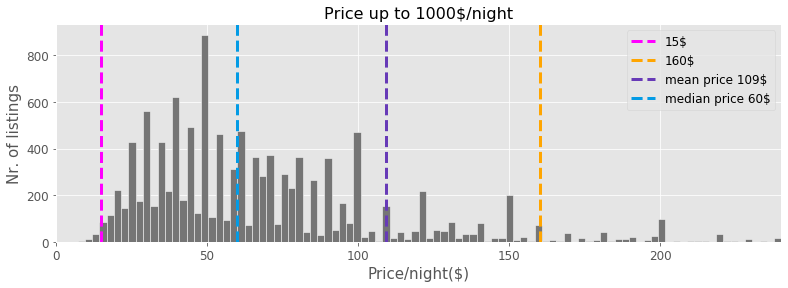

In [123]:
# Distribution of prices from £0 to £1000
plt.figure(figsize=(13,4))

listings.price.hist(bins=100, range=(0,240), ec='White', color = "#757575")

plt.margins(x=0)
plt.axvline(15, color='magenta', linestyle='--', label = "15$", lw=3)
plt.axvline(160, color='orange', linestyle='--', label = "160$", lw=3)
plt.axvline(listings['price'].mean(), color='#673ab7', linestyle='--', label="mean price 109$", lw=3)
plt.axvline(listings['price'].median(), color='#039be5', linestyle='--', label = "median price 60$", lw=3)

plt.title("Price up to 1000$/night", fontsize=16)
plt.xlabel("Price/night($)", fontsize = 15)
plt.ylabel("Nr. of listings", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.legend(loc='upper right', fontsize = 12)

plt.show()

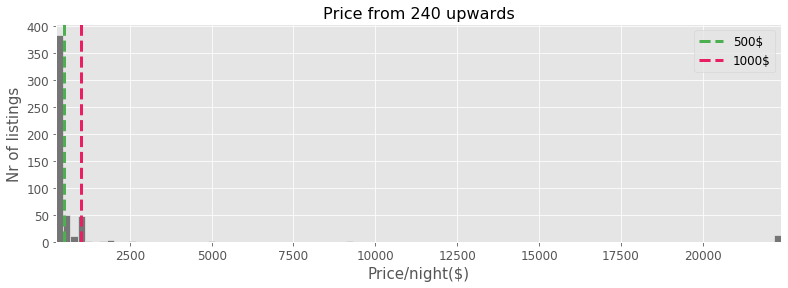

In [124]:
# Distribution of prices from $240 upwards
plt.figure(figsize=(13,4))

listings.price.hist(bins=100, range=(240, max(listings.price)), ec='White', color = "#757575")

plt.margins(x=0)
plt.axvline(500, color='#4caf50', linestyle='--', label = "500$", lw=3)
plt.axvline(1000, color='#e91e63', linestyle='--', label = "1000$", lw=3)

plt.title("Price from 240 upwards", fontsize=16)
plt.xlabel("Price/night($)", fontsize = 15)
plt.ylabel("Nr of listings", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(loc='upper right', fontsize = 12)
plt.show()

In [125]:
print("Number of listings: ", len(listings), "\n\nPrice/night >240$:")
print("\nProperty type:")
print(listings[listings['price']>=240].property_type.value_counts())
print("\nRoom type:")
print(listings[listings['price']>=240].room_type.value_counts())
print("\nPrice < 20$:")
print("\nProperty type:")
print(listings[listings['price']<15].property_type.value_counts())
print("\nRoom type:")
print(listings[listings['price']<15].room_type.value_counts())

Number of listings:  11996 

Price/night >240$:

Property type:
Apartment    473
Other         24
House         18
Name: property_type, dtype: int64

Room type:
Entire home/apt    468
Private room        29
Hotel room          18
Name: room_type, dtype: int64

Price < 20$:

Property type:
Apartment    45
House         3
Other         2
Name: property_type, dtype: int64

Room type:
Private room       36
Entire home/apt     9
Shared room         5
Name: room_type, dtype: int64


### Price outliers and extreme values

In [130]:
under15 = pd.DataFrame(listings[listings['price']<15])
under20 = pd.DataFrame(listings[listings['price']<20])
over240 = pd.DataFrame(listings[listings['price']>240])

In [131]:
under15.neighbourhood_cleansed.value_counts()

Ottakring       7
Josefstadt      6
Whring         6
Penzing         4
Landstra§e      4
Dbling         3
Hernals         3
Leopoldstadt    3
Margareten      2
Meidling        2
Floridsdorf     2
Hietzing        2
Innere Stadt    2
Neubau          1
Donaustadt      1
Brigittenau     1
Alsergrund      1
Name: neighbourhood_cleansed, dtype: int64

In [132]:
len(under15)

50

In [133]:
len(under20)

248

In [122]:
under20.describe()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,instant_bookable,host_days_active,air_conditioning,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,0.084677,3.560484,0.266129,1.830645,1.116935,1.004032,1.314516,15.939516,45.064516,7.737903,1.052419,4.302419,11.294355,561.826613,47.641129,19.262097,0.375000,1464.758065,0.044355,0.072581,0.217742,0.270161,0.185484,0.254032,0.903226,0.427419,0.173387,0.294355,0.201613,0.979839,0.145161,0.209677,0.104839,0.104839,0.076613,0.294355
std,0.278964,8.440574,0.442826,1.392413,0.384986,0.445381,1.348965,2.562650,115.004083,13.493733,0.313776,6.594169,72.502785,539.133559,93.831899,42.734088,0.485102,695.267139,0.206299,0.259972,0.413546,0.444941,0.389476,0.436196,0.296248,0.495704,0.379347,0.456674,0.402016,0.140836,0.352976,0.407902,0.306965,0.306965,0.266514,0.456674
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000,1.000000,0.000000,1.000000,30.000000,0.000000,1.000000,0.000000,978.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,16.000000,0.000000,0.000000,1.000000,0.000000,2.000000,190.000000,0.000000,3.000000,0.000000,1375.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,18.000000,0.000000,10.000000,1.000000,10.000000,7.000000,1125.000000,51.500000,15.250000,1.000000,1822.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,52.000000,1.000000,16.000000,4.000000,5.000000,16.000000,19.000000,900.000000,119.000000,4.000000,40.000000,1125.000000,1125.000000,365.000000,377.000000,1.000000,3256.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [118]:
over240.neighbourhood_cleansed.value_counts()

Innere Stadt            105
Landstra§e               46
Leopoldstadt             37
Favoriten                29
Alsergrund               28
Neubau                   24
Rudolfsheim-Fnfhaus     23
Margareten               22
Ottakring                22
Whring                  20
Wieden                   20
Donaustadt               20
Brigittenau              18
Meidling                 16
Mariahilf                16
Simmering                14
Josefstadt               12
Hernals                   8
Hietzing                  8
Dbling                   7
Penzing                   5
Liesing                   1
Name: neighbourhood_cleansed, dtype: int64

In [123]:
over240.describe()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,instant_bookable,host_days_active,air_conditioning,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,0.201597,34.614770,0.381238,6.129741,1.703593,2.191617,3.516966,1054.642715,102.385230,52.293413,3.039920,12.642715,2.686627,619.920160,230.896208,21.023952,0.768463,1883.369261,0.307385,0.237525,0.540918,0.890220,0.604790,0.417166,0.818363,0.604790,0.315369,0.367265,0.151697,0.992016,0.327345,0.081836,0.427146,0.141717,0.393214,0.037924
std,0.401594,48.552748,0.486176,3.491294,1.201444,1.605992,2.938403,3526.165840,326.158473,51.797758,2.454059,16.847970,6.653090,472.194144,128.605588,34.980729,0.422236,940.732849,0.461872,0.425992,0.498821,0.312928,0.489384,0.493584,0.385930,0.489384,0.465127,0.482542,0.359085,0.089085,0.469713,0.274389,0.495158,0.349108,0.488952,0.191204
min,0.000000,1.000000,0.000000,1.000000,0.500000,0.000000,0.000000,242.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,0.000000,4.000000,1.000000,1.000000,2.000000,300.000000,0.000000,30.000000,1.000000,0.000000,1.000000,180.000000,124.000000,1.000000,1.000000,1103.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,13.000000,0.000000,6.000000,1.000000,2.000000,3.000000,399.000000,0.000000,35.000000,2.000000,8.000000,2.000000,365.000000,281.000000,7.000000,1.000000,2002.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,47.000000,1.000000,8.000000,2.000000,3.000000,4.000000,500.000000,0.000000,70.000000,4.000000,20.000000,2.000000,1125.000000,350.000000,27.000000,1.000000,2814.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,661.000000,1.000000,16.000000,12.000000,10.000000,18.000000,22400.000000,4490.000000,500.000000,16.000000,130.000000,90.000000,1125.000000,365.000000,259.000000,1.000000,3528.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [134]:
listings.price.describe()

count    11996.000000
mean       109.231160
std        747.511151
min          9.000000
25%         40.000000
50%         60.000000
75%         90.000000
max      22400.000000
Name: price, dtype: float64

In [126]:
# Replacing values under £20 with £20
listings.loc[listings.price <= 15, 'price'] = 15

# Replacing values over £240 with £240
listings.loc[listings.price >= 240, 'price'] = 240

### Boxplot whith 1.5IQR and 3IQR

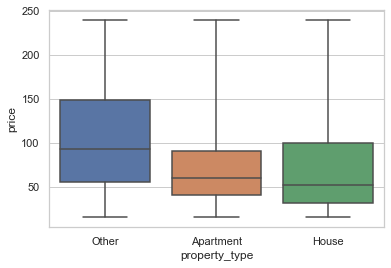

In [138]:
sns.boxplot(x=listings.property_type, y = listings.price, whis = 3)
plt.show()

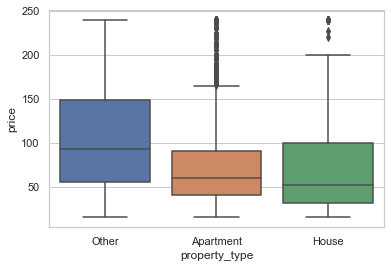

In [137]:
sns.boxplot(x=listings.property_type, y = listings.price, whis = 1.5)
plt.show()

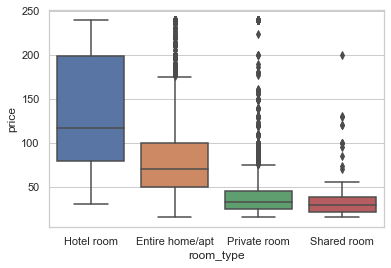

In [139]:
sns.boxplot(x=listings.room_type, y = listings.price, whis = 1.5)
plt.show()

In [142]:
listings.price.describe()

count    11996.000000
mean        75.221240
std         51.992832
min         15.000000
25%         40.000000
50%         60.000000
75%         90.000000
max        240.000000
Name: price, dtype: float64

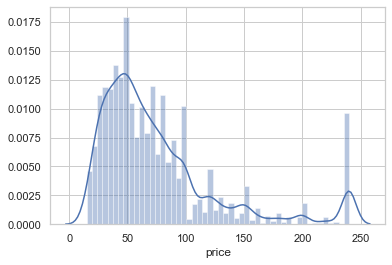

In [146]:
sns.distplot(listings.price)

### Host listings count

**Question: how many listings do hosts have on average? How many multi-listing hosts are there?**

Answer: the median number of listings that the host of each listing has is 2, i.e. on average (median) each listing is hosted by a host who also manages one other listing. The mean is much higher (10 in total) due to some hosts managing large numbers of listings (as discussed above in the Time Series section). About half of listings are from hosts with one listing, and half are from multi-listing hosts.

Two difficulties in discerning how many listings hosts have on average are:

+ this number is only known on the level of the listing, so hosts with more listings are represented more frequently (e.g a host with 10 listings may be represented up to 10 times in the dataset)
+ a host's other listings may not be in Vienna, so some multi-listing hosts may appear multiple times in the dataset, and others may appear only once

In [140]:
print("Median number of listings per host:", int(listings.host_listings_count.median()))
print("Mean number of listings per host:", int(round(listings.host_listings_count.mean())))
print(f"{int(round(100*len(listings[listings.host_listings_count == 1])/len(listings)))}% of listings are from hosts with one listing.")

Median number of listings per host: 2
Mean number of listings per host: 10
43% of listings are from hosts with one listing.


### Number of people accommodated, bathrooms, bedrooms and beds

**Question: what are the average number of people accommodated, bathrooms, bedrooms and beds in Airbnb listings in Vienna, and how do prices differ?**

Answer: the most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher nightly rates, with diminishing returns coming after about 10 people.

Some properties have very high looking values for some features (e.g. one property claims to have 17 bathrooms), but these will be left for now in the interests of time (as double-checking them would be time-consuming).

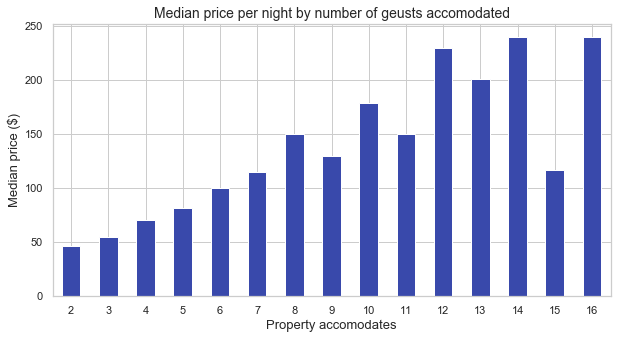

In [148]:
plt.figure(figsize=(10,5))

listings.groupby('accommodates').price.median().plot(kind='bar', color = '#3949ab')

plt.title('Median price per night by number of geusts accomodated', fontsize=14)
plt.xlabel('Property accomodates', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

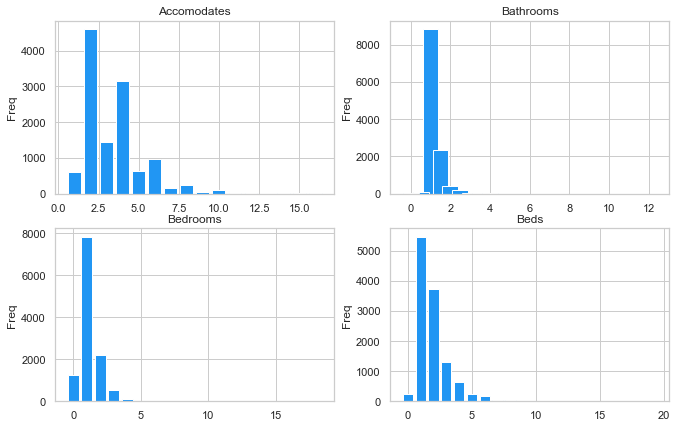

In [149]:
accomodatesFREQ = listings['accommodates'].value_counts()
bathroomsFREQ = listings['bathrooms'].value_counts()
bedroomsFREQ = listings['bedrooms'].value_counts()
bedsFREQ = listings['beds'].value_counts()

plt.figure(figsize = (11,7))

plt.subplot(2,2,1)
plt.bar(accomodatesFREQ.index, height = accomodatesFREQ, color = '#2196f3')
plt.title('Accomodates')
#plt.xlabel('Capacitatea camerei')
plt.ylabel('Freq')

plt.subplot(2,2,2)
plt.bar(bathroomsFREQ.index, height = bathroomsFREQ, ec="white", color = '#2196f3')
plt.title('Bathrooms')
#plt.xlabel('Nr. de băi')
plt.ylabel('Freq')

plt.subplot(2,2,3)
plt.bar(bedroomsFREQ.index, height = bedroomsFREQ, color = '#2196f3')
plt.title('Bedrooms')
#plt.xlabel('Nr. de dormitoare')
plt.ylabel('Freq')

plt.subplot(2,2,4)
plt.bar(bedsFREQ.index, height = bedsFREQ, color = '#2196f3')
plt.title('Beds')
#plt.xlabel('Nr. de paturi')
plt.ylabel('Freq')
plt.show()

In [123]:
bathroomsFREQ

1.0     8834
1.5     2330
2.0      437
2.5      174
0.5       76
3.0       59
3.5       32
4.0       17
0.0       14
4.5        7
5.0        6
8.0        5
6.0        2
6.5        1
11.0       1
12.0       1
Name: bathrooms, dtype: int64

## Categorical features  

Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.  

### Neighbourhood

**Question: which areas have the most Airbnb properties, and which are the most expensive?**

Answer: *Leopoldstadt* has the most Airbnb listings(1.273 listings), followed by *Landstrase* (1.062 listings). Inner Viennese districts have significantly more listings than outer districts.

However, the pattern with prices is slightly different. 
Innere Stadt is the most expensive area (almost double than any other district - 120`$`). 


#### [Viz done with TableauPublic](https://public.tableau.com/profile/zavoiu.ana#!/vizhome/MedianPriceandNumberofAirbnbListingsperDistrict-Vienna/Sheet1)

![Median Price and Number of Airbnb Listings per District](./Median_Price_Number_Airbnb_Listings_District.PNG)


In [150]:
# Renaming the neighbourhood column
listings.rename(columns={'neighbourhood_cleansed': 'district'}, inplace=True)

# Importing the Vienna borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('D:/disertation/project/vienna_data/raw/neighbourhoods.geojson')
map_df.rename(columns={'neighbourhood': 'district'}, inplace=True)
#map_df["district"].replace({'Rudolfsheim-Fnfhaus':'Rudolfsheim-Funfhaus', 'Dbling':'Dobling', 'Whring':"Wahring"}, inplace=True)
map_df

,district,neighbourhood_group,geometry
0,Leopoldstadt,None,"MULTIPOLYGON (((16.38484 48.22616, 16.38495 48..."
1,Landstra§e,None,"MULTIPOLYGON (((16.38681 48.21271, 16.38683 48..."
2,Innere Stadt,None,"MULTIPOLYGON (((16.36497 48.21590, 16.36498 48..."
3,Brigittenau,None,"MULTIPOLYGON (((16.38595 48.24764, 16.38611 48..."
4,Floridsdorf,None,"MULTIPOLYGON (((16.37817 48.28858, 16.37819 48..."
5,Donaustadt,None,"MULTIPOLYGON (((16.48378 48.17615, 16.48358 48..."
6,Liesing,None,"MULTIPOLYGON (((16.33924 48.15405, 16.33948 48..."
7,Alsergrund,None,"MULTIPOLYGON (((16.34255 48.21837, 16.34259 48..."
8,Penzing,None,"MULTIPOLYGON (((16.27508 48.21508, 16.27512 48..."
9,Mariahilf,None,"MULTIPOLYGON (((16.34200 48.19634, 16.34424 48..."


In [151]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
district_df = pd.DataFrame(listings.groupby('district').size())
district_df.rename(columns={0: 'number_of_listings'}, inplace=True)
district_df['median_price'] = listings.groupby('district').price.median().values

# Joining the dataframes
district_map_df = map_df.set_index('district').join(district_df)

In [152]:
district_map_df

,geometry,number_of_listings,median_price
district,,,
Leopoldstadt,"MULTIPOLYGON (((16.38484 48.22616, 16.38495 48...",1273,60.0
Landstra§e,"MULTIPOLYGON (((16.38681 48.21271, 16.38683 48...",1062,64.5
Innere Stadt,"MULTIPOLYGON (((16.36497 48.21590, 16.36498 48...",697,120.0
Brigittenau,"MULTIPOLYGON (((16.38595 48.24764, 16.38611 48...",478,63.0
Floridsdorf,"MULTIPOLYGON (((16.37817 48.28858, 16.37819 48...",149,45.0
Donaustadt,"MULTIPOLYGON (((16.48378 48.17615, 16.48358 48...",375,60.0
Liesing,"MULTIPOLYGON (((16.33924 48.15405, 16.33948 48...",59,54.0
Alsergrund,"MULTIPOLYGON (((16.34255 48.21837, 16.34259 48...",790,61.0
Penzing,"MULTIPOLYGON (((16.27508 48.21508, 16.27512 48...",288,50.0


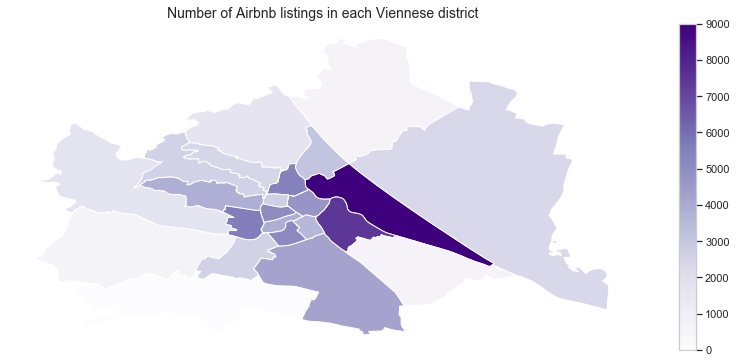

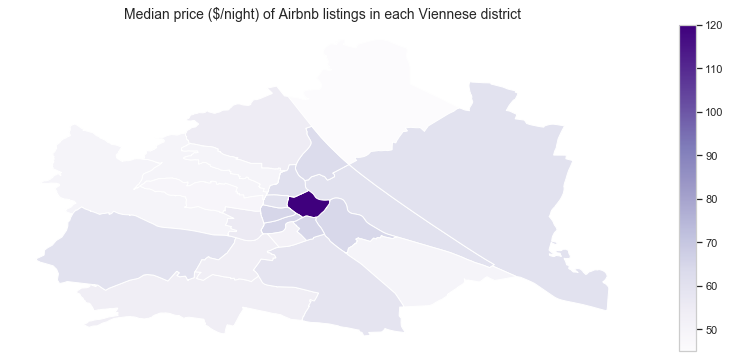

In [153]:
# Plotting the number of listings in each district
fig1, ax1 = plt.subplots(1, figsize=(15, 6))

district_map_df.plot(column='number_of_listings', cmap='Purples', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Viennese district', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))

district_map_df.plot(column='median_price', cmap='Purples', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price ($/night) of Airbnb listings in each Viennese district', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=min(district_map_df.median_price), vmax=max(district_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()




In [128]:
# Exporting GeoDataFrame to geojson for future visualisations

#district_map_df.to_file("D:/disertation/project/vienna_data/viz_district_map.geojson", driver='GeoJSON')

### Property and room types

**Question: what are the most common property and room types?**

Answer: about 95% of properties are apartments. The remainder are houses or more uncommon property types (e.g. 'bed and breakfast' or 'castle').

About 73% of listings are entire homes (i.e. you are renting the entire property on your own). Most of the remainder are private rooms (i.e. you are renting a bedroom and possibly also a bathroom, but there will be other people in the property). Fewer than 1% are shared rooms (i.e. you are sharing a room with either the property owner or other guests).

In [154]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    
    listings[col].value_counts().plot(kind='bar', color = "#673ab7")
    
    plt.title(col)
    plt.xticks(rotation=-45)
    plt.show()

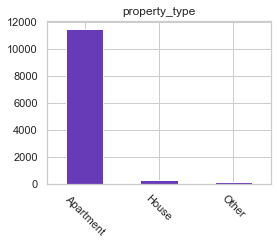

Apartment    0.96
House        0.02
Other        0.02
Name: property_type, dtype: float64


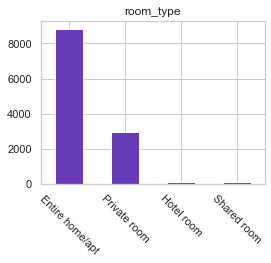

Entire home/apt    0.74
Private room       0.25
Hotel room         0.01
Shared room        0.01
Name: room_type, dtype: float64


In [155]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(round(listings[col].value_counts(normalize=True),2))

### Reviews

**Question: what is the distribution of reviews like?**

Answer: for every review category, the majority of listings that have had a review have received a 10/10 rating for that category (or 95-100/100 overall) - clearly people love their Airbnbs. 
Ratings 8 or below are rare. Guests seem to be most positive about communication, check-ins and accuracy. As noted previously, about a quarter of listings have not yet been reviewed.

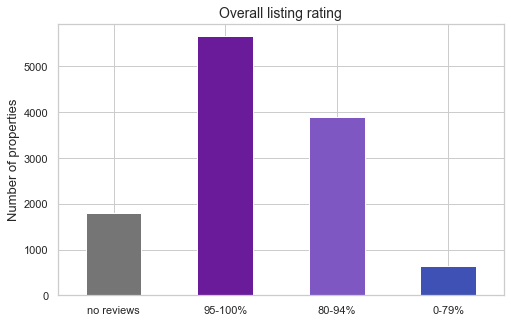

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.set_title('Overall listing rating', fontsize=14)

listings['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['#757575', '#6a1b9a', '#7e57c2', '#3f51b5' ], ax=ax)

ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

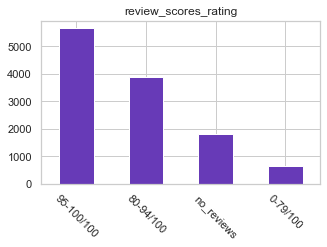

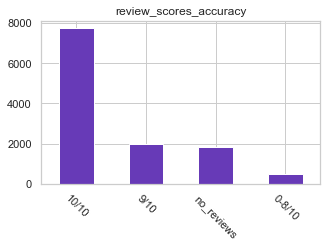

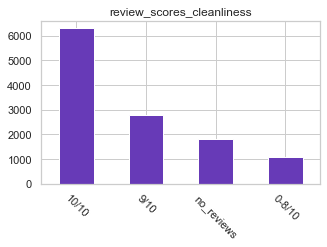

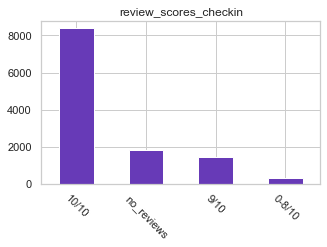

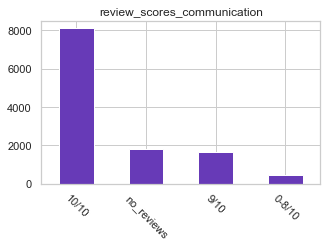

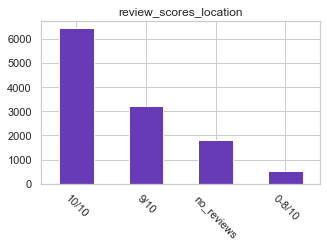

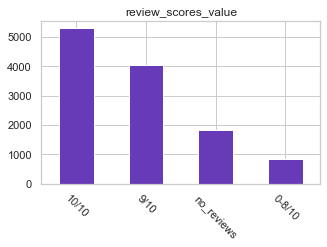

In [157]:
for col in list(listings.columns[listings.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

### First and last reviews

**Question: how long have listings been on the site, and how many listings have been reviewed recently?**

Answer: the most common time period in which currently live Airbnb listings had their first review is 2-3 years. This means that a lot of listings on the site have been active for at least a couple of years. Relatively few have been active for less than a year, however.

The most common categories for the time since a listing received its last review is 2-8 weeks adn 2-6 months. This means that a lot of listings have been reviewed relatively recently. 
However, there are still 2.000 listings which have not had a review for more than a year. The majority of these are probably what are sometimes referred to 'inactive' listings, because although they are technically live on the site, they do not have their calendards open and are not available to book.

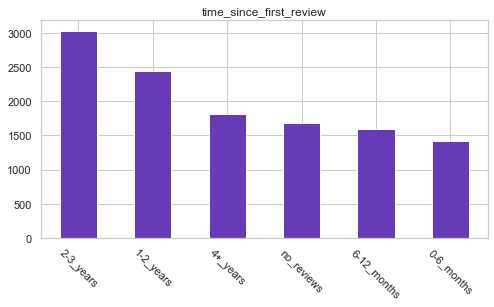

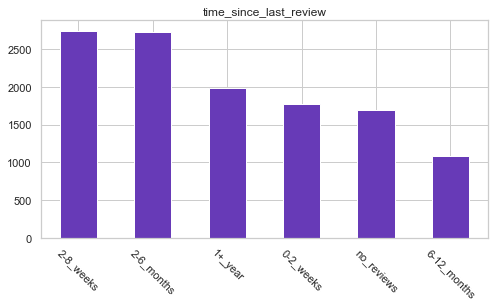

In [158]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

## Boolean (true or false) features

**Many features (e.g. for amenities) can be true or false. This section compares the proportions of these features that are true or false (to explore the data and also to drcide whether the feature is worth retaining), and the median price of each category (to explore the relationship between the category and price).**

In [159]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    listings.groupby(col).size().plot(kind='bar', ax=ax1, color=['#757575', '#26a69a'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    listings.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['#757575', '#26a69a'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (£)')
    ax2.set_xlabel('')
    
    plt.show()
    
    print(round(listings[col].value_counts(normalize=True),2))

### Superhosts

**Question: what proportion of Airbnb hosts are superhosts, and is it worth being one? (a question often asked by hosts)**

Answer: about 28% of hosts are superhosts. However, it does not seem to improve the median price per night of their Airbnb listings, so it is arguable whether or not it is worth it (from a purely financial perspective).

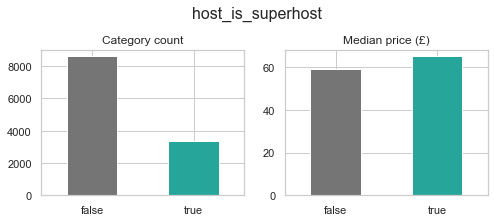

0.0    0.72
1.0    0.28
Name: host_is_superhost, dtype: float64


In [160]:
binary_count_and_price_plot('host_is_superhost')

### Host verification

**Question: how many hosts are verified, and is it worth it? (a question often asked by hosts)**

Answer: only about 31% of hosts are verified (e.g. by providing ID and verifying your phone number and email address), although it is something that hosts often think they are expected to do. Interestingly, however, despite the fact that one might expect the additional trust commanded by verified hosts to result in higher nightly prices, there is no discernable difference between the median nightly prices of listings with verified and unverified hosts. This column will be left in the dataframe, however, in case it has any useful interactions with other features.

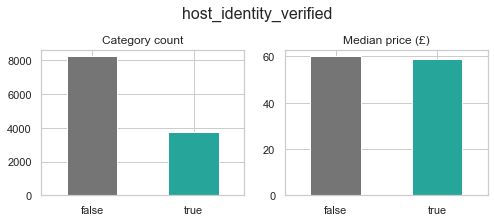

0.0    0.69
1.0    0.31
Name: host_identity_verified, dtype: float64


In [161]:
binary_count_and_price_plot('host_identity_verified')

### Instant booking

**Question: how many properties are instant bookable (i.e. able to be booked without messaging the host first), and is it worth it?**

Answer: only about 40% of properties are instant bookable. However, the added convenience seems to add just a little to the median price per night.

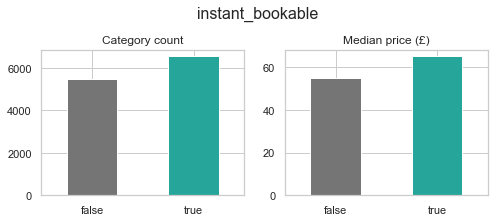

1    0.55
0    0.45
Name: instant_bookable, dtype: float64


In [162]:
binary_count_and_price_plot('instant_bookable')

### Amenities


**Question: which amenities are common, and which increase the price of an Airbnb listing?**

Answer: amenities can be split into four main groups:

1. Uncommon, but properties with it have a higher median price:
    * Air conditioning
    * Balcony
    * Bed linen
    * Child friendly
    * Parking
    * Long term stays allowed
    * Private entrance
    * Safe or security system
    * Self check-in
  
  
2. Most properties have it, and properties with it have a higher median price:
    * Elevator
    * Coffee machine
    * Basic cooking equipment
    * TV
    * Internet
  
  
3. Amenities for which there is no major difference in price between properties with and without it:
    * Washer, dryer and/or dishwasher
    * Greeted by the host
  
  
4. Uncommon, and properties with it have a lower median price:
    * Pets allowed
    * Smoking allowed



The takeaway from this is that there are some things that Airbnb hosts can do to try and improve their listing's price, although there is often not a simple causative relationship (e.g. if pets are allowed it may improve your price):

Make sure you have the necessities that your competitors also have, e.g. host greeting and white goods (a washer, dryer and/or dishwasher).
If you can, include some extras to make your property stand out and achieve a higher price. For example, you could buy an air conditioning system, allow self check-in and long-term stays, and make your property child-friendly.
Avoid pets as the additional wear and tear to your property might harm its financial performance.

In [163]:
listings.iloc[:,32:-2].columns

Index(['air_conditioning', 'balcony', 'bed_linen', 'tv', 'coffee_machine',
       'cooking_basics', 'white_goods', 'elevator', 'child_friendly',
       'parking', 'host_greeting', 'internet', 'long_term_stays',
       'pets_allowed', 'private_entrance', 'secure', 'self_check_in',
       'smoking_allowed'],
      dtype='object')

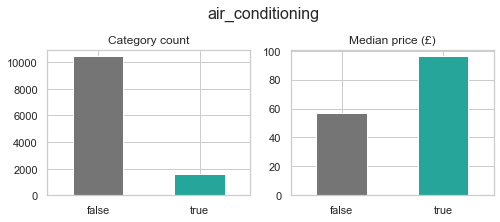

0.0    0.87
1.0    0.13
Name: air_conditioning, dtype: float64


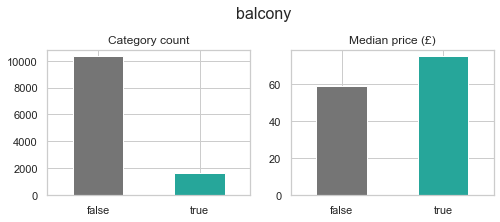

0.0    0.86
1.0    0.14
Name: balcony, dtype: float64


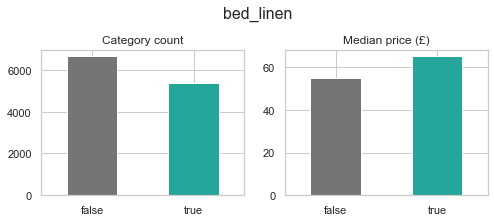

0.0    0.55
1.0    0.45
Name: bed_linen, dtype: float64


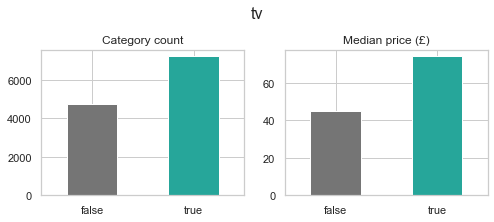

1.0    0.6
0.0    0.4
Name: tv, dtype: float64


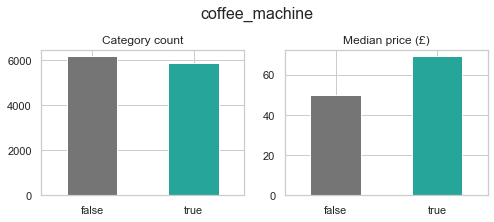

0.0    0.51
1.0    0.49
Name: coffee_machine, dtype: float64


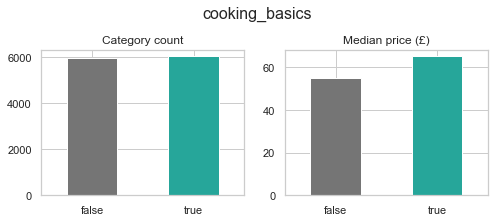

1.0    0.5
0.0    0.5
Name: cooking_basics, dtype: float64


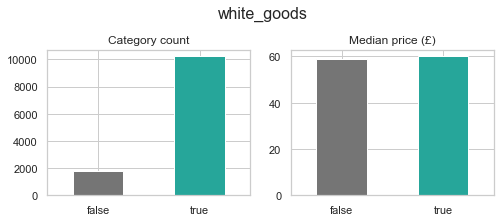

1.0    0.85
0.0    0.15
Name: white_goods, dtype: float64


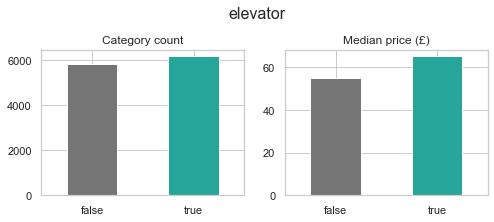

1.0    0.51
0.0    0.49
Name: elevator, dtype: float64


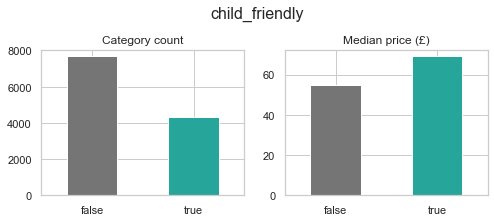

0.0    0.64
1.0    0.36
Name: child_friendly, dtype: float64


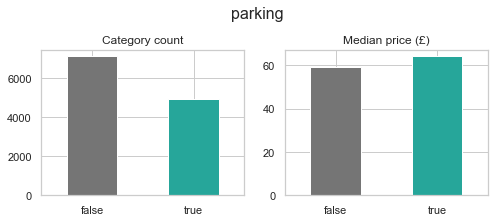

0.0    0.59
1.0    0.41
Name: parking, dtype: float64


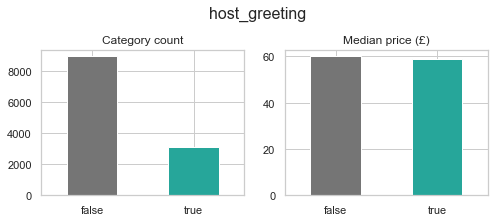

0.0    0.74
1.0    0.26
Name: host_greeting, dtype: float64


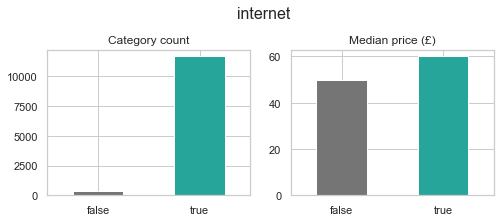

1.0    0.97
0.0    0.03
Name: internet, dtype: float64


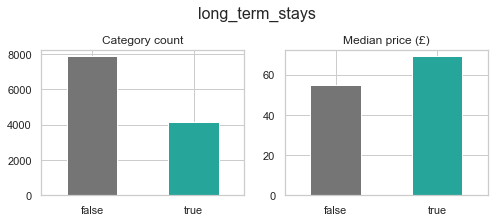

0.0    0.65
1.0    0.35
Name: long_term_stays, dtype: float64


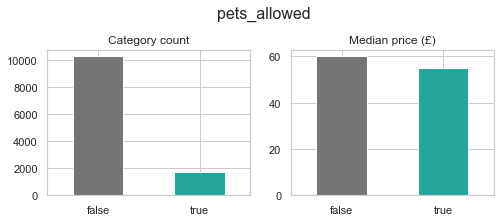

0.0    0.86
1.0    0.14
Name: pets_allowed, dtype: float64


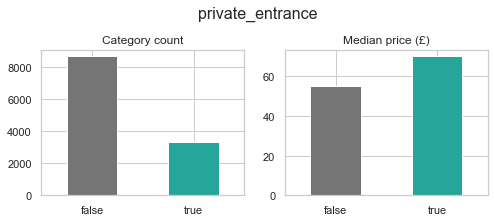

0.0    0.72
1.0    0.28
Name: private_entrance, dtype: float64


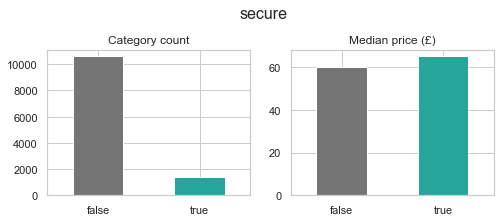

0.0    0.88
1.0    0.12
Name: secure, dtype: float64


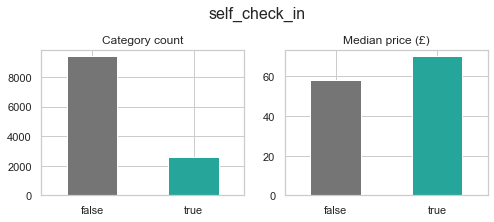

0.0    0.78
1.0    0.22
Name: self_check_in, dtype: float64


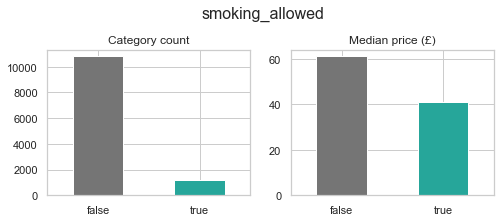

0.0    0.9
1.0    0.1
Name: smoking_allowed, dtype: float64


In [164]:
for col in listings.iloc[:,32:-2].columns:
    binary_count_and_price_plot(col)

listings.groupby('room_type').price.median().plot(figsize=(8,4), kind='bar', color = "#3f51b5")
plt.title("Mediana prețul pe noapte în funcție de tipul camerei")
plt.xticks(fontsize = 12, rotation = 45)
plt.yticks(fontsize = 12)
plt.ylabel("Preț($)")
plt.show()

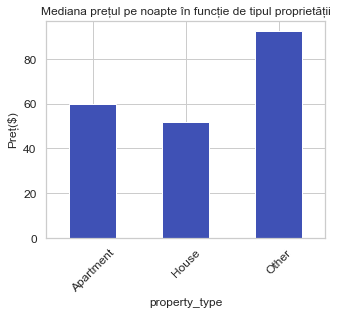

In [165]:
listings.groupby('property_type').price.median().plot(figsize=(5,4), kind='bar', color = "#3f51b5")
plt.title("Mediana prețul pe noapte în funcție de tipul proprietății")
plt.xticks(fontsize = 12, rotation = 45)
plt.yticks(fontsize = 12)
plt.ylabel("Preț($)")
plt.show()

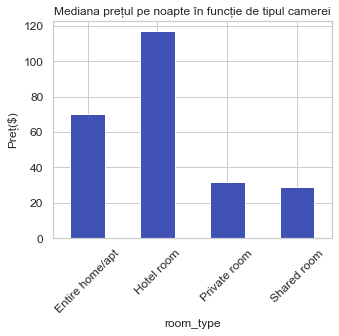

In [166]:
listings.groupby('room_type').price.median().plot(figsize=(5,4), kind='bar', color = "#3f51b5")
plt.title("Mediana prețul pe noapte în funcție de tipul camerei")
plt.xticks(fontsize = 12, rotation = 45)
plt.yticks(fontsize = 12)
plt.ylabel("Preț($)")
plt.show()

# Preparing Data for Modeling


Categorical variables will now be one-hot encoded and the resulting dataframe along with the *listings* dataframe will be expoted to .csv for further modelling in a separate notebook.


In [178]:
listings.to_csv(r'D:/disertation/project/vienna_data/listings.csv')

**Dataset before dummy tranformation**

In [167]:
listings.shape

(11996, 52)

In [168]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11996 entries, 15883 to 42926580
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_time           11996 non-null  object 
 1   host_response_rate           11996 non-null  object 
 2   host_acceptance_rate         11996 non-null  object 
 3   host_is_superhost            11996 non-null  float64
 4   host_listings_count          11996 non-null  float64
 5   host_identity_verified       11996 non-null  float64
 6   district                     11996 non-null  object 
 7   property_type                11996 non-null  object 
 8   room_type                    11996 non-null  object 
 9   accommodates                 11996 non-null  int64  
 10  bathrooms                    11996 non-null  float64
 11  bedrooms                     11996 non-null  float64
 12  beds                         11996 non-null  float64
 13  price    

In [169]:
#data to be used in tableau
viz_listings = copy.deepcopy(listings)
viz_listings [['latitude', 'longitude']] = latitude_logitude

In [177]:
viz_listings.to_csv(r'D:/disertation/project/vienna_data/viz_listings.csv')

In [170]:
viz_listings.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,district,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,host_days_active,air_conditioning,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,time_since_first_review,time_since_last_review,latitude,longitude
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15883,within an hour,100%,90-99%,0.0,6.0,1.0,Donaustadt,Other,Hotel room,3,1.0,1.0,2.0,85,0,0,2,10,1,365,314,11,80-94/100,10/10,10/10,10/10,10/10,9/10,9/10,1,moderate,3749.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4+_years,2-8_weeks,48.24262,16.42767
38768,within an hour,100%,100%,0.0,3.0,0.0,Leopoldstadt,Apartment,Entire home/apt,5,1.0,1.0,3.0,65,150,35,2,12,3,100,201,313,80-94/100,10/10,10/10,10/10,10/10,10/10,10/10,0,strict_14_with_grace_period,3534.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4+_years,0-2_weeks,48.21823,16.37926
40625,within an hour,90-99%,50-89%,1.0,16.0,1.0,Rudolfsheim-Fnfhaus,Apartment,Entire home/apt,6,1.0,2.0,4.0,130,0,55,5,15,1,180,324,153,95-100/100,10/10,10/10,10/10,10/10,9/10,9/10,1,moderate,3528.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,4+_years,2-6_months,48.18434,16.32701
51287,within an hour,100%,100%,0.0,3.0,0.0,Leopoldstadt,Apartment,Entire home/apt,3,1.0,0.0,2.0,60,150,30,2,8,3,100,137,294,80-94/100,10/10,9/10,10/10,10/10,10/10,9/10,0,strict_14_with_grace_period,3534.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4+_years,2-8_weeks,48.21851,16.37781
70568,within a day,90-99%,0-49%,1.0,7.0,1.0,Donaustadt,Apartment,Entire home/apt,2,1.0,1.0,1.0,59,150,40,2,15,3,365,365,10,80-94/100,9/10,10/10,9/10,10/10,9/10,9/10,0,strict_14_with_grace_period,3342.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4+_years,1+_year,48.22224,16.42460


In [146]:
viz_listings.isna().sum()

host_response_time             0
host_response_rate             0
host_acceptance_rate           0
host_is_superhost              0
host_listings_count            0
host_identity_verified         0
district                       0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
price                          0
security_deposit               0
cleaning_fee                   0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
availability_365               0
number_of_reviews              0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
instant_bookable               0
cancellati

In [171]:
transformed_listings = pd.get_dummies(listings)

In [172]:
transformed_listings.head()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,instant_bookable,host_days_active,air_conditioning,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_0-49%,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,host_response_rate_unknown,host_acceptance_rate_0-49%,host_acceptance_rate_100%,host_acceptance_rate_50-89%,host_acceptance_rate_90-99%,host_acceptance_rate_unknown,district_Alsergrund,district_Brigittenau,district_Donaustadt,district_Dbling,district_Favoriten,district_Floridsdorf,district_Hernals,district_Hietzing,district_Innere Stadt,district_Josefstadt,district_Landstra§e,district_Leopoldstadt,district_Liesing,district_Margareten,district_Mariahilf,district_Meidling,district_Neubau,district_Ottakring,district_Penzing,district_Rudolfsheim-Fnfhaus,district_Simmering,district_Wieden,district_Whring,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_rating_no_reviews,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_accuracy_no_reviews,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_cleanliness_no_reviews,review_scores_checkin_0-8/10,review_scores_checkin_10/10,review_scores_checkin_9/10,review_scores_checkin_no_reviews,review_scores_communication_0-8/10,review_scores_communication_10/10,review_scores_communication_9/10,review_scores_communication_no_reviews,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_location_no_reviews,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,review_scores_value_no_reviews,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,time_since_first_review_0-6_months,time_since_first_review_1-2_years,time_since_first_review_2-3_years,time_since_first_review_4+_years,time_since_first_review_6-12_months,time_since_first_review_no_reviews,time_since_last_review_0-2_weeks,time_since_last_review_1+_year,time_since_last_review_2-6_months,time_since_last_review_2-8_weeks,time_since_last_review_6-12_months,time_since_last_review_no_reviews
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15883,0.0,6.0,1.0,3,1.0,1.0,2.0,85,0,0,2,10,1,365,314,11,1,3749.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
38768,0.0,3.0,0.0,5,1.0,1.0,3.0,65,150,35,2,12,3,100,201,313,0,3534.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
40625,1.0,16.0,1.0,6,1.0,2.0,4.0,130,0,55,5,15,1,180,324,153,1,3528.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
51287,0.0,3.0,0.0,3,1.0,0.

In [176]:
#data to be used in modelling
transformed_listings.to_csv(r'D:/disertation/project/vienna_data/transformed_listings.csv')

In [173]:
transformed_listings.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11996 entries, 15883 to 42926580
Data columns (total 124 columns):
 #   Column                                           Dtype  
---  ------                                           -----  
 0   host_is_superhost                                float64
 1   host_listings_count                              float64
 2   host_identity_verified                           float64
 3   accommodates                                     int64  
 4   bathrooms                                        float64
 5   bedrooms                                         float64
 6   beds                                             float64
 7   price                                            int64  
 8   security_deposit                                 int64  
 9   cleaning_fee                                     int64  
 10  guests_included                                  int64  
 11  extra_people                                     int64  
 12  minimum_ni

**Transformed listings dataset after dummy transformation**

In [174]:
transformed_listings.shape

(11996, 124)